In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

from tensorboard.plugins.hparams import api as hp

In [2]:
%reload_ext tensorboard

In [3]:
!rm -rf ./logs/ 

In [2]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [3]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def train_test_split_ts_2d_raw(X, h):
    return(X[:-h],X[-h:])


def train_test_split_ts(X, y, test_size=0.2):
    r = X.shape[0]
    split_index = int((1-test_size)*r)
    return(X[:split_index,:,:],X[split_index:,:,:],y[:split_index],y[split_index:])

def train_test_split_ts_index(X, y, split_index):
    r = X.shape[0]
    return(X[:split_index,:,:],X[split_index:,:,:],y[:split_index],y[split_index:])

def train_test_split_ts_2d(X, y, test_size=0.2):
    r = X.shape[0]
    split_index = int((1-test_size)*r)
    return(X[:split_index,:],X[split_index:,:],y[:split_index],y[split_index:])

def train_test_split_ts_2d_index(X, y, split_index):
    r = X.shape[0]
    return(X[:split_index,:],X[split_index:,:],y[:split_index],y[split_index:])

In [4]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size)]
        data_X.append(a)
        data_Y.append(dataset[i + window_size])
    return(np.array(data_X), np.array(data_Y))

In [5]:
def forecast(first_item, model, h, n_step):
    x = first_item
    result = []
    #x = np.reshape(x,(1,20))
    for i in range(h):
        y = model.predict(np.reshape(x,(1,n_step)))
        result.append(y)
        x = np.append(x[1:],np.array(y))
    return(np.array(result))   

In [6]:
def build_model(n_steps, n_units, learning_rate, optimizer_name):
    model = keras.Sequential()
    if len(n_units) == 1:
        model.add(layers.Dense(n_units[0], activation=tf.nn.relu, input_dim=n_steps))
    else:  
        model.add(layers.Dense(n_units[0], activation=tf.nn.relu, input_dim=n_steps))
        for i in range(1,len(n_units)):
            model.add(layers.Dense(n_units[i], activation=tf.nn.relu))
    
    model.add(layers.Dense(1))
    
    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate)

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [7]:
def cv_hparam_tunning(x, n_steps, num_units, optimizer, learning_rate,
                      training_window=15, forecast_window=1, freq=12,epochs=1):

    fuzzify(x)
    L = len(x)
    errors = []
    
    for i in range(0, L - (training_window+forecast_window)*freq, freq):   

        raw_seq = x[i:i+(training_window + forecast_window)*freq]

        X, y_test = train_test_split_ts_2d_raw(raw_seq, forecast_window*freq) 
        X_train, y_train = split_sequence(X, n_steps)

        #estimator = KerasRegressor(build_fn=baseline_ model(n_steps), epochs=100, batch_size=5, verbose=0)
        model = build_model(n_steps, num_units, learning_rate, optimizer)


        #EPOCHS = 100
        model.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)

        y_hat = forecast(np.append(X_train[-1][1:],np.array(y_train[-1])), model, freq, n_steps)
        y_hat = np.reshape(y_hat,len(y_test))
        if np.any(np.isnan(y_hat)):
            errors.append(np.nan)
        else:
            errors.append(math.sqrt(mean_squared_error(y_test,y_hat)))

        #errors.append(math.sqrt(mean_squared_error(y_test,y_hat)))
        
    return(np.nanmean(errors))

In [8]:
def uni_deseasonalize(ts,freq=12):
    ts = np.array(ts)
    avgs = np.zeros(freq)
    stds = np.zeros(freq)
    N = len(ts)
    #averages = np.zeros((freq,n))
    temp = ts
    result = np.zeros((N))
    for j in range(freq):
        Idx = np.arange(j,N,freq)
        avgs[j] = temp[Idx].mean()
        stds[j] = temp[Idx].std()
        result[Idx] = (temp[Idx] - temp[Idx].mean())#/temp[Idx].std()
    return(result, avgs) 

In [16]:
data = np.load('data.npy')
lat = np.load('lat.npy')
lon = np.load('lon.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'data.npy'

In [339]:
x = data[27,6,]

In [9]:
data = pd.read_csv("extremes.csv")

In [10]:
x = data.iloc[1:,1].values

In [18]:
x = np.array(data.iloc[1:,1:].values)

In [13]:
n = 30
# Set forecasting window length (in years)
m = 3
# Set annual sampling rate
f = 12 
L = x.shape[0]
errors = []
j = 0


start = 1977
origin = 1977
# Set annual sampling rate
freq = 12
h = m*f
n_steps = 20

index = (origin - start) * f

#x.ts <- x[index:length(x)-1]

train_start = index
train_end = train_start+n*f-1

test_start = train_end + 1
test_end = test_start + m*f -1

In [38]:
raw_seq = x[index:index+(n+m)*f,:]

In [14]:
# define input sequence
raw_seq = x[index:index+(n+m)*f]
X, y_test = train_test_split_ts_2d_raw(raw_seq, h) 
#X, avgs = uni_deseasonalize(X)
x_train, y_train = split_sequence(X, n_steps)

In [15]:
x_test, y_test = split_sequence(y_test, n_steps)

In [65]:
X_train, y_train = split_sequence(X[:,0], n_steps)

In [66]:
oni_x = np.reshape(X[19:-1,1], (X_train.shape[0],1))
oni_y = np.reshape(X[19:-1,1], (X_train.shape[0],1))

In [67]:
X_train = np.hstack((oni_x, X_train))

In [12]:
# define input sequence
raw_seq = x[index:index+(n+m)*f]
X, y_test = train_test_split_ts_2d_raw(raw_seq, h) 
#X, avgs = uni_deseasonalize(X)

X_train, y_train = split_sequence(X, n_steps)

In [55]:
n_units = [16]
learning_rate = 0.001
optimizer = 'adam'
epochs = 100

In [59]:
n_units = [200,100,50,30,20,10]
learning_rate = 0.001
optimizer = 'adam'
epochs = 500

In [60]:
model = build_model(n_steps, n_units, learning_rate, optimizer)
model.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
y_hat = forecast(np.append(X_train[-1][1:],np.array(y_train[-1])), model, h, n_steps)
y_hat = np.reshape(y_hat,len(y_test))

In [116]:
#avgs = np.tile(avgs, int(len(y_hat)/f))
#stds = np.tile(stds, int(len(y_hat)/f))

In [61]:
math.sqrt(mean_squared_error(y_test,y_hat))

8.306955666928031

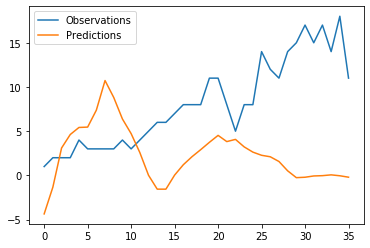

In [58]:
plt.plot(range(len(y_test)), y_test, label="Observations")
plt.plot(range(len(y_test)), y_hat, label="Predictions")
plt.legend()

In [112]:
y_test

array([ 1,  2,  2,  2,  4,  3,  3,  3,  3,  4,  3,  4,  5,  6,  6,  7,  8,
        8,  8, 11, 11,  8,  5,  8,  8, 14, 12, 11, 14, 15, 17, 15, 17, 14,
       18, 11])

In [ ]:
if np.any(np.isnan(y_hat)):
    errors.append(np.nan)
else:
    errors.append(math.sqrt(mean_squared_error(y_test,y_hat)))

In [42]:
%reload_ext tensorboard

In [39]:
!rm -rf ./logs/ 

In [18]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_RMSE = 'RootMeanSquaredError'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_RMSE, display_name='RMSE')],
  )

In [19]:
def train_test_model(hparams):
    model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape = n_steps),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=tf.nn.relu),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(1),
    ])
    model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='mean_squared_error',
      metrics=['RootMeanSquaredError'],
    )

    model.fit(x_train, y_train, epochs=100) # Run with 1 epoch to speed things up for demo purposes
    _, rmse = model.evaluate(x_test, y_test)
    return rmse


In [20]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        rmse = train_test_model(hparams)
        tf.summary.scalar(METRIC_RMSE, rmse, step=10)

In [21]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            hparams = {
                HP_NUM_UNITS: num_units,
                HP_DROPOUT: dropout_rate,
                HP_OPTIMIZER: optimizer,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams)
            session_num += 1



--- Starting trial: run-0
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam'}
Train on 340 samples
Epoch 1/100
340/340 [==============================] - 0s 708us/sample - loss: 100.9799 - RootMeanSquaredError: 10.0489
Epoch 2/100
340/340 [==============================] - 0s 38us/sample - loss: 66.5301 - RootMeanSquaredError: 8.1566
Epoch 3/100
340/340 [==============================] - 0s 45us/sample - loss: 42.1816 - RootMeanSquaredError: 6.4947
Epoch 4/100
340/340 [==============================] - 0s 42us/sample - loss: 35.9247 - RootMeanSquaredError: 5.9937
Epoch 5/100
340/340 [==============================] - 0s 44us/sample - loss: 30.5159 - RootMeanSquaredError: 5.5241
Epoch 6/100
340/340 [==============================] - 0s 37us/sample - loss: 29.6098 - RootMeanSquaredError: 5.4415
Epoch 7/100
340/340 [==============================] - 0s 47us/sample - loss: 26.3905 - RootMeanSquaredError: 5.1372
Epoch 8/100
340/340 [==============================] - 0s 44us/sample - loss

340/340 [==============================] - 0s 38us/sample - loss: 14.9712 - RootMeanSquaredError: 3.8693
Epoch 70/100
340/340 [==============================] - 0s 37us/sample - loss: 15.7952 - RootMeanSquaredError: 3.9743
Epoch 71/100
340/340 [==============================] - 0s 37us/sample - loss: 14.4606 - RootMeanSquaredError: 3.8027
Epoch 72/100
340/340 [==============================] - 0s 36us/sample - loss: 15.1663 - RootMeanSquaredError: 3.8944
Epoch 73/100
340/340 [==============================] - 0s 36us/sample - loss: 15.4613 - RootMeanSquaredError: 3.9321
Epoch 74/100
340/340 [==============================] - 0s 39us/sample - loss: 15.1340 - RootMeanSquaredError: 3.8902
Epoch 75/100
340/340 [==============================] - 0s 36us/sample - loss: 13.8728 - RootMeanSquaredError: 3.7246
Epoch 76/100
340/340 [==============================] - 0s 38us/sample - loss: 14.8760 - RootMeanSquaredError: 3.8569
Epoch 77/100
340/340 [==============================] - 0s 34us/sampl

340/340 [==============================] - 0s 44us/sample - loss: 39.9630 - RootMeanSquaredError: 6.3216
Epoch 37/100
340/340 [==============================] - 0s 38us/sample - loss: 39.9686 - RootMeanSquaredError: 6.3221
Epoch 38/100
340/340 [==============================] - 0s 34us/sample - loss: 39.9809 - RootMeanSquaredError: 6.3230
Epoch 39/100
340/340 [==============================] - 0s 35us/sample - loss: 39.9642 - RootMeanSquaredError: 6.3217
Epoch 40/100
340/340 [==============================] - 0s 37us/sample - loss: 39.9641 - RootMeanSquaredError: 6.3217
Epoch 41/100
340/340 [==============================] - 0s 34us/sample - loss: 39.9692 - RootMeanSquaredError: 6.3221
Epoch 42/100
340/340 [==============================] - 0s 34us/sample - loss: 39.9717 - RootMeanSquaredError: 6.3223
Epoch 43/100
340/340 [==============================] - 0s 42us/sample - loss: 39.9566 - RootMeanSquaredError: 6.3211
Epoch 44/100
340/340 [==============================] - 0s 35us/sampl

340/340 [==============================] - 0s 34us/sample - loss: 132.2072 - RootMeanSquaredError: 11.4981
Epoch 4/100
340/340 [==============================] - 0s 34us/sample - loss: 105.8923 - RootMeanSquaredError: 10.2904
Epoch 5/100
340/340 [==============================] - 0s 36us/sample - loss: 86.4946 - RootMeanSquaredError: 9.3002
Epoch 6/100
340/340 [==============================] - 0s 40us/sample - loss: 75.1630 - RootMeanSquaredError: 8.6697
Epoch 7/100
340/340 [==============================] - 0s 37us/sample - loss: 62.2242 - RootMeanSquaredError: 7.8882
Epoch 8/100
340/340 [==============================] - 0s 36us/sample - loss: 52.3068 - RootMeanSquaredError: 7.2323
Epoch 9/100
340/340 [==============================] - 0s 35us/sample - loss: 54.6920 - RootMeanSquaredError: 7.3954
Epoch 10/100
340/340 [==============================] - 0s 36us/sample - loss: 46.0226 - RootMeanSquaredError: 6.7840
Epoch 11/100
340/340 [==============================] - 0s 36us/sample 

340/340 [==============================] - 0s 36us/sample - loss: 22.7713 - RootMeanSquaredError: 4.7719
Epoch 73/100
340/340 [==============================] - 0s 36us/sample - loss: 20.1983 - RootMeanSquaredError: 4.4943
Epoch 74/100
340/340 [==============================] - 0s 33us/sample - loss: 21.1778 - RootMeanSquaredError: 4.6019
Epoch 75/100
340/340 [==============================] - 0s 36us/sample - loss: 21.5407 - RootMeanSquaredError: 4.6412
Epoch 76/100
340/340 [==============================] - 0s 37us/sample - loss: 19.5431 - RootMeanSquaredError: 4.4208
Epoch 77/100
340/340 [==============================] - 0s 35us/sample - loss: 21.8822 - RootMeanSquaredError: 4.6778
Epoch 78/100
340/340 [==============================] - 0s 34us/sample - loss: 22.0297 - RootMeanSquaredError: 4.6936
Epoch 79/100
340/340 [==============================] - 0s 36us/sample - loss: 21.7235 - RootMeanSquaredError: 4.6608
Epoch 80/100
340/340 [==============================] - 0s 37us/sampl

340/340 [==============================] - 0s 35us/sample - loss: 39.9635 - RootMeanSquaredError: 6.3217
Epoch 40/100
340/340 [==============================] - 0s 36us/sample - loss: 39.9628 - RootMeanSquaredError: 6.3216
Epoch 41/100
340/340 [==============================] - 0s 36us/sample - loss: 39.9624 - RootMeanSquaredError: 6.3216
Epoch 42/100
340/340 [==============================] - 0s 33us/sample - loss: 39.9573 - RootMeanSquaredError: 6.3212
Epoch 43/100
340/340 [==============================] - 0s 35us/sample - loss: 39.9808 - RootMeanSquaredError: 6.3230
Epoch 44/100
340/340 [==============================] - 0s 36us/sample - loss: 39.9624 - RootMeanSquaredError: 6.3216
Epoch 45/100
340/340 [==============================] - 0s 33us/sample - loss: 39.9588 - RootMeanSquaredError: 6.3213
Epoch 46/100
340/340 [==============================] - 0s 35us/sample - loss: 39.9718 - RootMeanSquaredError: 6.3223
Epoch 47/100
340/340 [==============================] - 0s 36us/sampl

340/340 [==============================] - 0s 36us/sample - loss: 32.8900 - RootMeanSquaredError: 5.7350
Epoch 7/100
340/340 [==============================] - 0s 38us/sample - loss: 36.8255 - RootMeanSquaredError: 6.0684
Epoch 8/100
340/340 [==============================] - 0s 38us/sample - loss: 31.0339 - RootMeanSquaredError: 5.5708
Epoch 9/100
340/340 [==============================] - 0s 38us/sample - loss: 27.0712 - RootMeanSquaredError: 5.2030
Epoch 10/100
340/340 [==============================] - 0s 38us/sample - loss: 33.2777 - RootMeanSquaredError: 5.7687
Epoch 11/100
340/340 [==============================] - 0s 36us/sample - loss: 23.3304 - RootMeanSquaredError: 4.8302
Epoch 12/100
340/340 [==============================] - 0s 35us/sample - loss: 27.5330 - RootMeanSquaredError: 5.2472
Epoch 13/100
340/340 [==============================] - 0s 37us/sample - loss: 24.5395 - RootMeanSquaredError: 4.9537
Epoch 14/100
340/340 [==============================] - 0s 42us/sample -

340/340 [==============================] - 0s 36us/sample - loss: 12.2127 - RootMeanSquaredError: 3.4947
Epoch 76/100
340/340 [==============================] - 0s 38us/sample - loss: 12.6378 - RootMeanSquaredError: 3.5550
Epoch 77/100
340/340 [==============================] - 0s 37us/sample - loss: 12.7009 - RootMeanSquaredError: 3.5638
Epoch 78/100
340/340 [==============================] - 0s 38us/sample - loss: 11.7149 - RootMeanSquaredError: 3.4227
Epoch 79/100
340/340 [==============================] - 0s 37us/sample - loss: 12.6713 - RootMeanSquaredError: 3.5597
Epoch 80/100
340/340 [==============================] - 0s 39us/sample - loss: 12.6803 - RootMeanSquaredError: 3.5609
Epoch 81/100
340/340 [==============================] - 0s 37us/sample - loss: 12.7292 - RootMeanSquaredError: 3.5678
Epoch 82/100
340/340 [==============================] - 0s 38us/sample - loss: 12.2195 - RootMeanSquaredError: 3.4956
Epoch 83/100
340/340 [==============================] - 0s 37us/sampl

340/340 [==============================] - 0s 43us/sample - loss: 39.9810 - RootMeanSquaredError: 6.3231
Epoch 43/100
340/340 [==============================] - 0s 46us/sample - loss: 39.9697 - RootMeanSquaredError: 6.3222
Epoch 44/100
340/340 [==============================] - 0s 42us/sample - loss: 39.9610 - RootMeanSquaredError: 6.3215
Epoch 45/100
340/340 [==============================] - 0s 45us/sample - loss: 39.9848 - RootMeanSquaredError: 6.3234
Epoch 46/100
340/340 [==============================] - 0s 37us/sample - loss: 39.9614 - RootMeanSquaredError: 6.3215
Epoch 47/100
340/340 [==============================] - 0s 39us/sample - loss: 39.9886 - RootMeanSquaredError: 6.3237
Epoch 48/100
340/340 [==============================] - 0s 39us/sample - loss: 39.9528 - RootMeanSquaredError: 6.3208
Epoch 49/100
340/340 [==============================] - 0s 44us/sample - loss: 39.9784 - RootMeanSquaredError: 6.3228
Epoch 50/100
340/340 [==============================] - 0s 40us/sampl

340/340 [==============================] - 0s 43us/sample - loss: 44.7928 - RootMeanSquaredError: 6.6927
Epoch 10/100
340/340 [==============================] - 0s 38us/sample - loss: 42.7517 - RootMeanSquaredError: 6.5385
Epoch 11/100
340/340 [==============================] - 0s 36us/sample - loss: 38.5955 - RootMeanSquaredError: 6.2125
Epoch 12/100
340/340 [==============================] - 0s 46us/sample - loss: 35.9582 - RootMeanSquaredError: 5.9965
Epoch 13/100
340/340 [==============================] - 0s 39us/sample - loss: 34.8781 - RootMeanSquaredError: 5.9058
Epoch 14/100
340/340 [==============================] - 0s 41us/sample - loss: 34.5418 - RootMeanSquaredError: 5.8772
Epoch 15/100
340/340 [==============================] - 0s 43us/sample - loss: 36.3554 - RootMeanSquaredError: 6.0295
Epoch 16/100
340/340 [==============================] - 0s 41us/sample - loss: 32.3797 - RootMeanSquaredError: 5.6903
Epoch 17/100
340/340 [==============================] - 0s 44us/sampl

340/340 [==============================] - 0s 39us/sample - loss: 18.5518 - RootMeanSquaredError: 4.3072
Epoch 79/100
340/340 [==============================] - 0s 37us/sample - loss: 14.2544 - RootMeanSquaredError: 3.7755
Epoch 80/100
340/340 [==============================] - 0s 37us/sample - loss: 17.7592 - RootMeanSquaredError: 4.2142
Epoch 81/100
340/340 [==============================] - 0s 41us/sample - loss: 16.7902 - RootMeanSquaredError: 4.0976
Epoch 82/100
340/340 [==============================] - 0s 38us/sample - loss: 14.5061 - RootMeanSquaredError: 3.8087
Epoch 83/100
340/340 [==============================] - 0s 47us/sample - loss: 16.5837 - RootMeanSquaredError: 4.0723
Epoch 84/100
340/340 [==============================] - 0s 38us/sample - loss: 18.6376 - RootMeanSquaredError: 4.3171
Epoch 85/100
340/340 [==============================] - 0s 37us/sample - loss: 16.3303 - RootMeanSquaredError: 4.0411
Epoch 86/100
340/340 [==============================] - 0s 39us/sampl

340/340 [==============================] - 0s 36us/sample - loss: 1636833111.3412 - RootMeanSquaredError: 40457.7930
Epoch 41/100
340/340 [==============================] - 0s 34us/sample - loss: 1049489673.7882 - RootMeanSquaredError: 32395.8281
Epoch 42/100
340/340 [==============================] - 0s 37us/sample - loss: 672902509.9294 - RootMeanSquaredError: 25940.3633
Epoch 43/100
340/340 [==============================] - 0s 36us/sample - loss: 431444772.1412 - RootMeanSquaredError: 20771.2480
Epoch 44/100
340/340 [==============================] - 0s 35us/sample - loss: 276629683.0118 - RootMeanSquaredError: 16632.1875
Epoch 45/100
340/340 [==============================] - 0s 34us/sample - loss: 177367002.9176 - RootMeanSquaredError: 13317.9209
Epoch 46/100
340/340 [==============================] - 0s 35us/sample - loss: 113722639.2471 - RootMeanSquaredError: 10664.0820
Epoch 47/100
340/340 [==============================] - 0s 39us/sample - loss: 72915566.9647 - RootMeanSquar

In [23]:
!kill 27181

In [24]:
%tensorboard --logdir logs/hparam_tuning

In [26]:
HP_NUM_UNITS1 = hp.HParam('num_units 1', hp.Discrete([4,8,16])) 
HP_NUM_UNITS2 = hp.HParam('num_units 2', hp.Discrete([4,8]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
METRIC_ACCURACY = 'RootMeanSquaredError'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS1,HP_NUM_UNITS2, HP_DROPOUT,HP_L2 ,HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_RMSE, display_name='rmse')],
  )

In [30]:
def train_test_model(hparams):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape = n_steps),
        layers.Dense(hparams[HP_NUM_UNITS1], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
        layers.Dropout(hparams[HP_DROPOUT]),
        layers.Dense(hparams[HP_NUM_UNITS2], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
        layers.Dense(1)
    ])

    model.compile(optimizer=hparams[HP_OPTIMIZER],
                loss='mean_squared_error',
                metrics=['RootMeanSquaredError'])

    model.fit(x_train, y_train, epochs=100) 
    _, rmse = model.evaluate(x_test, y_test)
    return rmse

In [28]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [46]:
session_num = 0
for num_units1 in HP_NUM_UNITS1.domain.values:
    for num_units2 in HP_NUM_UNITS2.domain.values:
        for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
            for l2 in (HP_L2.domain.min_value, HP_L2.domain.max_value):
                for optimizer in HP_OPTIMIZER.domain.values:
          
                    hparams = {
                        HP_NUM_UNITS1: num_units1,
                        HP_NUM_UNITS2: num_units2,
                        HP_DROPOUT: dropout_rate,
                        HP_L2: l2,
                        HP_OPTIMIZER: optimizer
                    }
                    run_name = "run-%d" % session_num
                    print('--- Starting trial: %s' % run_name)
                    print({h.name: hparams[h] for h in hparams})
                    run('logs/hparam_tuning/' + run_name, hparams)
                    session_num += 1

--- Starting trial: run-0
{'num_units 1': 4, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'RMSprop'}
Train on 340 samples
Epoch 1/100
340/340 [==============================] - 0s 1ms/sample - loss: 64.7609 - RootMeanSquaredError: 8.0468
Epoch 2/100
340/340 [==============================] - 0s 35us/sample - loss: 61.0419 - RootMeanSquaredError: 7.8123
Epoch 3/100
340/340 [==============================] - 0s 36us/sample - loss: 60.1014 - RootMeanSquaredError: 7.7519
Epoch 4/100
340/340 [==============================] - 0s 35us/sample - loss: 53.6415 - RootMeanSquaredError: 7.3234
Epoch 5/100
340/340 [==============================] - 0s 37us/sample - loss: 53.6274 - RootMeanSquaredError: 7.3224
Epoch 6/100
340/340 [==============================] - 0s 39us/sample - loss: 53.2334 - RootMeanSquaredError: 7.2955
Epoch 7/100
340/340 [==============================] - 0s 39us/sample - loss: 50.2358 - RootMeanSquaredError: 7.0870
Epoch 8/100
340/340 [============

340/340 [==============================] - 0s 41us/sample - loss: 18.7930 - RootMeanSquaredError: 4.3343
Epoch 70/100
340/340 [==============================] - 0s 42us/sample - loss: 18.6215 - RootMeanSquaredError: 4.3145
Epoch 71/100
340/340 [==============================] - 0s 40us/sample - loss: 19.7804 - RootMeanSquaredError: 4.4467
Epoch 72/100
340/340 [==============================] - 0s 38us/sample - loss: 20.5508 - RootMeanSquaredError: 4.5325
Epoch 73/100
340/340 [==============================] - 0s 39us/sample - loss: 21.9291 - RootMeanSquaredError: 4.6821
Epoch 74/100
340/340 [==============================] - 0s 37us/sample - loss: 18.4364 - RootMeanSquaredError: 4.2930
Epoch 75/100
340/340 [==============================] - 0s 39us/sample - loss: 20.6245 - RootMeanSquaredError: 4.5407
Epoch 76/100
340/340 [==============================] - 0s 41us/sample - loss: 19.2549 - RootMeanSquaredError: 4.3873
Epoch 77/100
340/340 [==============================] - 0s 38us/sampl

340/340 [==============================] - 0s 38us/sample - loss: 36.9658 - RootMeanSquaredError: 6.0790
Epoch 37/100
340/340 [==============================] - 0s 41us/sample - loss: 39.9663 - RootMeanSquaredError: 6.3210
Epoch 38/100
340/340 [==============================] - 0s 43us/sample - loss: 36.5025 - RootMeanSquaredError: 6.0408
Epoch 39/100
340/340 [==============================] - 0s 42us/sample - loss: 37.3566 - RootMeanSquaredError: 6.1111
Epoch 40/100
340/340 [==============================] - 0s 36us/sample - loss: 34.7313 - RootMeanSquaredError: 5.8924
Epoch 41/100
340/340 [==============================] - 0s 38us/sample - loss: 33.9707 - RootMeanSquaredError: 5.8275
Epoch 42/100
340/340 [==============================] - 0s 40us/sample - loss: 39.5093 - RootMeanSquaredError: 6.2847
Epoch 43/100
340/340 [==============================] - 0s 40us/sample - loss: 34.9140 - RootMeanSquaredError: 5.9078
Epoch 44/100
340/340 [==============================] - 0s 37us/sampl

340/340 [==============================] - 0s 39us/sample - loss: 18087.1923 - RootMeanSquaredError: 7.2298
Epoch 4/100
340/340 [==============================] - 0s 38us/sample - loss: 18074.8390 - RootMeanSquaredError: 6.9178
Epoch 5/100
340/340 [==============================] - 0s 39us/sample - loss: 18064.0820 - RootMeanSquaredError: 6.7109
Epoch 6/100
340/340 [==============================] - 0s 37us/sample - loss: 18054.2606 - RootMeanSquaredError: 6.5690
Epoch 7/100
340/340 [==============================] - 0s 39us/sample - loss: 18045.2080 - RootMeanSquaredError: 6.4825
Epoch 8/100
340/340 [==============================] - 0s 36us/sample - loss: 18036.5685 - RootMeanSquaredError: 6.4260
Epoch 9/100
340/340 [==============================] - 0s 36us/sample - loss: 18028.1821 - RootMeanSquaredError: 6.3888
Epoch 10/100
340/340 [==============================] - 0s 39us/sample - loss: 18019.9700 - RootMeanSquaredError: 6.3648
Epoch 11/100
340/340 [=============================

340/340 [==============================] - 0s 36us/sample - loss: 17550.9797 - RootMeanSquaredError: 6.3217
Epoch 71/100
340/340 [==============================] - 0s 35us/sample - loss: 17543.2756 - RootMeanSquaredError: 6.3216
Epoch 72/100
340/340 [==============================] - 0s 37us/sample - loss: 17535.5795 - RootMeanSquaredError: 6.3219
Epoch 73/100
340/340 [==============================] - 0s 42us/sample - loss: 17527.8784 - RootMeanSquaredError: 6.3217
Epoch 74/100
340/340 [==============================] - 0s 38us/sample - loss: 17520.1801 - RootMeanSquaredError: 6.3215
Epoch 75/100
340/340 [==============================] - 0s 39us/sample - loss: 17512.4930 - RootMeanSquaredError: 6.3222
Epoch 76/100
340/340 [==============================] - 0s 36us/sample - loss: 17504.7993 - RootMeanSquaredError: 6.3221
Epoch 77/100
340/340 [==============================] - 0s 36us/sample - loss: 17497.1181 - RootMeanSquaredError: 6.3229
Epoch 78/100
340/340 [=======================

340/340 [==============================] - 0s 42us/sample - loss: 31.1841 - RootMeanSquaredError: 5.5835
Epoch 37/100
340/340 [==============================] - 0s 39us/sample - loss: 33.1744 - RootMeanSquaredError: 5.7590
Epoch 38/100
340/340 [==============================] - 0s 40us/sample - loss: 29.4319 - RootMeanSquaredError: 5.4243
Epoch 39/100
340/340 [==============================] - 0s 43us/sample - loss: 26.9045 - RootMeanSquaredError: 5.1862
Epoch 40/100
340/340 [==============================] - 0s 41us/sample - loss: 30.3432 - RootMeanSquaredError: 5.5077
Epoch 41/100
340/340 [==============================] - 0s 41us/sample - loss: 32.8435 - RootMeanSquaredError: 5.7302
Epoch 42/100
340/340 [==============================] - 0s 40us/sample - loss: 30.8519 - RootMeanSquaredError: 5.5537
Epoch 43/100
340/340 [==============================] - 0s 40us/sample - loss: 32.6026 - RootMeanSquaredError: 5.7091
Epoch 44/100
340/340 [==============================] - 0s 39us/sampl

340/340 [==============================] - 0s 40us/sample - loss: 126.1578 - RootMeanSquaredError: 11.2315
Epoch 4/100
340/340 [==============================] - 0s 40us/sample - loss: 122.1585 - RootMeanSquaredError: 11.0520
Epoch 5/100
340/340 [==============================] - 0s 41us/sample - loss: 121.8732 - RootMeanSquaredError: 11.0391
Epoch 6/100
340/340 [==============================] - 0s 37us/sample - loss: 120.7364 - RootMeanSquaredError: 10.9875
Epoch 7/100
340/340 [==============================] - 0s 35us/sample - loss: 121.6316 - RootMeanSquaredError: 11.0281
Epoch 8/100
340/340 [==============================] - 0s 37us/sample - loss: 120.4401 - RootMeanSquaredError: 10.9740
Epoch 9/100
340/340 [==============================] - 0s 40us/sample - loss: 118.6498 - RootMeanSquaredError: 10.8921
Epoch 10/100
340/340 [==============================] - 0s 40us/sample - loss: 116.9094 - RootMeanSquaredError: 10.8119
Epoch 11/100
340/340 [==============================] - 0s 

340/340 [==============================] - 0s 44us/sample - loss: 27.9609 - RootMeanSquaredError: 5.2866
Epoch 73/100
340/340 [==============================] - 0s 42us/sample - loss: 34.6090 - RootMeanSquaredError: 5.8819
Epoch 74/100
340/340 [==============================] - 0s 40us/sample - loss: 33.8076 - RootMeanSquaredError: 5.8134
Epoch 75/100
340/340 [==============================] - 0s 38us/sample - loss: 28.1833 - RootMeanSquaredError: 5.3076
Epoch 76/100
340/340 [==============================] - 0s 41us/sample - loss: 28.7920 - RootMeanSquaredError: 5.3647
Epoch 77/100
340/340 [==============================] - 0s 39us/sample - loss: 29.7448 - RootMeanSquaredError: 5.4528
Epoch 78/100
340/340 [==============================] - 0s 39us/sample - loss: 34.0495 - RootMeanSquaredError: 5.8341
Epoch 79/100
340/340 [==============================] - 0s 47us/sample - loss: 30.0977 - RootMeanSquaredError: 5.4850
Epoch 80/100
340/340 [==============================] - 0s 41us/sampl

340/340 [==============================] - 0s 37us/sample - loss: 40.4050 - RootMeanSquaredError: 6.3217
Epoch 40/100
340/340 [==============================] - 0s 41us/sample - loss: 40.4025 - RootMeanSquaredError: 6.3216
Epoch 41/100
340/340 [==============================] - 0s 40us/sample - loss: 40.4239 - RootMeanSquaredError: 6.3233
Epoch 42/100
340/340 [==============================] - 0s 40us/sample - loss: 40.4135 - RootMeanSquaredError: 6.3225
Epoch 43/100
340/340 [==============================] - 0s 36us/sample - loss: 40.4097 - RootMeanSquaredError: 6.3222
Epoch 44/100
340/340 [==============================] - 0s 39us/sample - loss: 40.4128 - RootMeanSquaredError: 6.3224
Epoch 45/100
340/340 [==============================] - 0s 37us/sample - loss: 40.4206 - RootMeanSquaredError: 6.3231
Epoch 46/100
340/340 [==============================] - 0s 39us/sample - loss: 40.4091 - RootMeanSquaredError: 6.3222
Epoch 47/100
340/340 [==============================] - 0s 41us/sampl

340/340 [==============================] - 0s 32us/sample - loss: 69.5870 - RootMeanSquaredError: 8.3412
Epoch 7/100
340/340 [==============================] - 0s 32us/sample - loss: 64.7150 - RootMeanSquaredError: 8.0439
Epoch 8/100
340/340 [==============================] - 0s 32us/sample - loss: 63.6923 - RootMeanSquaredError: 7.9801
Epoch 9/100
340/340 [==============================] - 0s 32us/sample - loss: 57.4599 - RootMeanSquaredError: 7.5795
Epoch 10/100
340/340 [==============================] - 0s 32us/sample - loss: 56.3009 - RootMeanSquaredError: 7.5027
Epoch 11/100
340/340 [==============================] - 0s 31us/sample - loss: 54.9259 - RootMeanSquaredError: 7.4105
Epoch 12/100
340/340 [==============================] - 0s 32us/sample - loss: 53.3953 - RootMeanSquaredError: 7.3065
Epoch 13/100
340/340 [==============================] - 0s 33us/sample - loss: 53.9198 - RootMeanSquaredError: 7.3423
Epoch 14/100
340/340 [==============================] - 0s 34us/sample -

340/340 [==============================] - 0s 33us/sample - loss: 25.2824 - RootMeanSquaredError: 5.0273
Epoch 76/100
340/340 [==============================] - 0s 33us/sample - loss: 24.5447 - RootMeanSquaredError: 4.9534
Epoch 77/100
340/340 [==============================] - 0s 32us/sample - loss: 22.6168 - RootMeanSquaredError: 4.7548
Epoch 78/100
340/340 [==============================] - 0s 32us/sample - loss: 28.2992 - RootMeanSquaredError: 5.3189
Epoch 79/100
340/340 [==============================] - 0s 32us/sample - loss: 21.1359 - RootMeanSquaredError: 4.5964
Epoch 80/100
340/340 [==============================] - 0s 32us/sample - loss: 21.7757 - RootMeanSquaredError: 4.6655
Epoch 81/100
340/340 [==============================] - 0s 35us/sample - loss: 22.1312 - RootMeanSquaredError: 4.7034
Epoch 82/100
340/340 [==============================] - 0s 32us/sample - loss: 23.1673 - RootMeanSquaredError: 4.8123
Epoch 83/100
340/340 [==============================] - 0s 36us/sampl

340/340 [==============================] - 0s 34us/sample - loss: 103.2676 - RootMeanSquaredError: 10.1617
Epoch 42/100
340/340 [==============================] - 0s 31us/sample - loss: 103.1787 - RootMeanSquaredError: 10.1573
Epoch 43/100
340/340 [==============================] - 0s 31us/sample - loss: 102.6995 - RootMeanSquaredError: 10.1337
Epoch 44/100
340/340 [==============================] - 0s 32us/sample - loss: 101.5772 - RootMeanSquaredError: 10.0782
Epoch 45/100
340/340 [==============================] - 0s 32us/sample - loss: 101.0730 - RootMeanSquaredError: 10.0531
Epoch 46/100
340/340 [==============================] - 0s 32us/sample - loss: 100.3611 - RootMeanSquaredError: 10.0177
Epoch 47/100
340/340 [==============================] - 0s 31us/sample - loss: 99.4307 - RootMeanSquaredError: 9.9711
Epoch 48/100
340/340 [==============================] - 0s 31us/sample - loss: 98.9673 - RootMeanSquaredError: 9.9478
Epoch 49/100
340/340 [==============================] - 0

340/340 [==============================] - 0s 30us/sample - loss: 43.4749 - RootMeanSquaredError: 6.5727
Epoch 9/100
340/340 [==============================] - 0s 31us/sample - loss: 42.3498 - RootMeanSquaredError: 6.4865
Epoch 10/100
340/340 [==============================] - 0s 30us/sample - loss: 41.5835 - RootMeanSquaredError: 6.4272
Epoch 11/100
340/340 [==============================] - 0s 31us/sample - loss: 41.1058 - RootMeanSquaredError: 6.3899
Epoch 12/100
340/340 [==============================] - 0s 31us/sample - loss: 40.8016 - RootMeanSquaredError: 6.3661
Epoch 13/100
340/340 [==============================] - 0s 32us/sample - loss: 40.6001 - RootMeanSquaredError: 6.3502
Epoch 14/100
340/340 [==============================] - 0s 32us/sample - loss: 40.4543 - RootMeanSquaredError: 6.3388
Epoch 15/100
340/340 [==============================] - 0s 31us/sample - loss: 40.3808 - RootMeanSquaredError: 6.3330
Epoch 16/100
340/340 [==============================] - 0s 31us/sample

340/340 [==============================] - 0s 31us/sample - loss: 40.2649 - RootMeanSquaredError: 6.3244
Epoch 78/100
340/340 [==============================] - 0s 30us/sample - loss: 40.2360 - RootMeanSquaredError: 6.3221
Epoch 79/100
340/340 [==============================] - 0s 32us/sample - loss: 40.2366 - RootMeanSquaredError: 6.3222
Epoch 80/100
340/340 [==============================] - 0s 29us/sample - loss: 40.2356 - RootMeanSquaredError: 6.3221
Epoch 81/100
340/340 [==============================] - 0s 31us/sample - loss: 40.2324 - RootMeanSquaredError: 6.3219
Epoch 82/100
340/340 [==============================] - 0s 30us/sample - loss: 40.2335 - RootMeanSquaredError: 6.3220
Epoch 83/100
340/340 [==============================] - 0s 30us/sample - loss: 40.2292 - RootMeanSquaredError: 6.3216
Epoch 84/100
340/340 [==============================] - 0s 31us/sample - loss: 40.2287 - RootMeanSquaredError: 6.3216
Epoch 85/100
340/340 [==============================] - 0s 31us/sampl

340/340 [==============================] - 0s 31us/sample - loss: 32.9381 - RootMeanSquaredError: 5.7384
Epoch 45/100
340/340 [==============================] - 0s 31us/sample - loss: 34.3826 - RootMeanSquaredError: 5.8630
Epoch 46/100
340/340 [==============================] - 0s 33us/sample - loss: 30.8714 - RootMeanSquaredError: 5.5555
Epoch 47/100
340/340 [==============================] - 0s 31us/sample - loss: 37.3566 - RootMeanSquaredError: 6.1113
Epoch 48/100
340/340 [==============================] - 0s 33us/sample - loss: 32.2021 - RootMeanSquaredError: 5.6740
Epoch 49/100
340/340 [==============================] - 0s 31us/sample - loss: 31.8184 - RootMeanSquaredError: 5.6401
Epoch 50/100
340/340 [==============================] - 0s 33us/sample - loss: 33.4911 - RootMeanSquaredError: 5.7864
Epoch 51/100
340/340 [==============================] - 0s 32us/sample - loss: 30.9924 - RootMeanSquaredError: 5.5664
Epoch 52/100
340/340 [==============================] - 0s 31us/sampl

340/340 [==============================] - 0s 31us/sample - loss: 210.3857 - RootMeanSquaredError: 14.5044
Epoch 12/100
340/340 [==============================] - 0s 30us/sample - loss: 197.2756 - RootMeanSquaredError: 14.0452
Epoch 13/100
340/340 [==============================] - 0s 30us/sample - loss: 162.6070 - RootMeanSquaredError: 12.7514
Epoch 14/100
340/340 [==============================] - 0s 31us/sample - loss: 187.1645 - RootMeanSquaredError: 13.6805
Epoch 15/100
340/340 [==============================] - 0s 31us/sample - loss: 173.6657 - RootMeanSquaredError: 13.1779
Epoch 16/100
340/340 [==============================] - 0s 31us/sample - loss: 161.9576 - RootMeanSquaredError: 12.7259
Epoch 17/100
340/340 [==============================] - 0s 35us/sample - loss: 138.2629 - RootMeanSquaredError: 11.7581
Epoch 18/100
340/340 [==============================] - 0s 36us/sample - loss: 160.1342 - RootMeanSquaredError: 12.6541
Epoch 19/100
340/340 [==============================]

340/340 [==============================] - 0s 33us/sample - loss: 86.6517 - RootMeanSquaredError: 9.3082
Epoch 80/100
340/340 [==============================] - 0s 31us/sample - loss: 85.9681 - RootMeanSquaredError: 9.2714
Epoch 81/100
340/340 [==============================] - 0s 31us/sample - loss: 84.5569 - RootMeanSquaredError: 9.1950
Epoch 82/100
340/340 [==============================] - 0s 31us/sample - loss: 84.5215 - RootMeanSquaredError: 9.1931
Epoch 83/100
340/340 [==============================] - 0s 32us/sample - loss: 83.8015 - RootMeanSquaredError: 9.1539
Epoch 84/100
340/340 [==============================] - 0s 32us/sample - loss: 81.4745 - RootMeanSquaredError: 9.0259
Epoch 85/100
340/340 [==============================] - 0s 31us/sample - loss: 82.4535 - RootMeanSquaredError: 9.0799
Epoch 86/100
340/340 [==============================] - 0s 30us/sample - loss: 81.7861 - RootMeanSquaredError: 9.0431
Epoch 87/100
340/340 [==============================] - 0s 31us/sampl

340/340 [==============================] - 0s 31us/sample - loss: 117.9913 - RootMeanSquaredError: 6.3215
Epoch 47/100
340/340 [==============================] - 0s 31us/sample - loss: 117.9894 - RootMeanSquaredError: 6.3241
Epoch 48/100
340/340 [==============================] - 0s 30us/sample - loss: 117.9204 - RootMeanSquaredError: 6.3214
Epoch 49/100
340/340 [==============================] - 0s 32us/sample - loss: 117.8804 - RootMeanSquaredError: 6.3209
Epoch 50/100
340/340 [==============================] - 0s 34us/sample - loss: 117.8587 - RootMeanSquaredError: 6.3219
Epoch 51/100
340/340 [==============================] - 0s 30us/sample - loss: 117.8310 - RootMeanSquaredError: 6.3224
Epoch 52/100
340/340 [==============================] - 0s 31us/sample - loss: 117.7821 - RootMeanSquaredError: 6.3213
Epoch 53/100
340/340 [==============================] - 0s 31us/sample - loss: 117.7584 - RootMeanSquaredError: 6.3221
Epoch 54/100
340/340 [==============================] - 0s 30

340/340 [==============================] - 0s 33us/sample - loss: 32.8681 - RootMeanSquaredError: 5.7321
Epoch 14/100
340/340 [==============================] - 0s 34us/sample - loss: 34.7785 - RootMeanSquaredError: 5.8964
Epoch 15/100
340/340 [==============================] - 0s 31us/sample - loss: 27.8788 - RootMeanSquaredError: 5.2790
Epoch 16/100
340/340 [==============================] - 0s 33us/sample - loss: 25.9543 - RootMeanSquaredError: 5.0934
Epoch 17/100
340/340 [==============================] - 0s 32us/sample - loss: 27.1150 - RootMeanSquaredError: 5.2061
Epoch 18/100
340/340 [==============================] - 0s 32us/sample - loss: 25.6693 - RootMeanSquaredError: 5.0654
Epoch 19/100
340/340 [==============================] - 0s 31us/sample - loss: 30.5339 - RootMeanSquaredError: 5.5247
Epoch 20/100
340/340 [==============================] - 0s 31us/sample - loss: 26.3331 - RootMeanSquaredError: 5.1305
Epoch 21/100
340/340 [==============================] - 0s 31us/sampl

340/340 [==============================] - 0s 34us/sample - loss: 19.7178 - RootMeanSquaredError: 4.4392
Epoch 83/100
340/340 [==============================] - 0s 34us/sample - loss: 18.0064 - RootMeanSquaredError: 4.2421
Epoch 84/100
340/340 [==============================] - 0s 35us/sample - loss: 16.6122 - RootMeanSquaredError: 4.0745
Epoch 85/100
340/340 [==============================] - 0s 34us/sample - loss: 16.0229 - RootMeanSquaredError: 4.0015
Epoch 86/100
340/340 [==============================] - 0s 34us/sample - loss: 15.5840 - RootMeanSquaredError: 3.9463
Epoch 87/100
340/340 [==============================] - 0s 34us/sample - loss: 16.9045 - RootMeanSquaredError: 4.1102
Epoch 88/100
340/340 [==============================] - 0s 34us/sample - loss: 15.5994 - RootMeanSquaredError: 3.9482
Epoch 89/100
340/340 [==============================] - 0s 37us/sample - loss: 17.8484 - RootMeanSquaredError: 4.2234
Epoch 90/100
340/340 [==============================] - 0s 36us/sampl

340/340 [==============================] - 0s 32us/sample - loss: 17.4379 - RootMeanSquaredError: 4.1745
Epoch 50/100
340/340 [==============================] - 0s 32us/sample - loss: 18.3553 - RootMeanSquaredError: 4.2830
Epoch 51/100
340/340 [==============================] - 0s 32us/sample - loss: 18.0065 - RootMeanSquaredError: 4.2420
Epoch 52/100
340/340 [==============================] - 0s 32us/sample - loss: 17.4671 - RootMeanSquaredError: 4.1780
Epoch 53/100
340/340 [==============================] - 0s 31us/sample - loss: 17.5354 - RootMeanSquaredError: 4.1861
Epoch 54/100
340/340 [==============================] - 0s 30us/sample - loss: 18.0318 - RootMeanSquaredError: 4.2450
Epoch 55/100
340/340 [==============================] - 0s 31us/sample - loss: 18.1122 - RootMeanSquaredError: 4.2545
Epoch 56/100
340/340 [==============================] - 0s 33us/sample - loss: 16.9678 - RootMeanSquaredError: 4.1178
Epoch 57/100
340/340 [==============================] - 0s 31us/sampl

340/340 [==============================] - 0s 30us/sample - loss: 996.4170 - RootMeanSquaredError: 6.3444
Epoch 17/100
340/340 [==============================] - 0s 30us/sample - loss: 996.3812 - RootMeanSquaredError: 6.3746
Epoch 18/100
340/340 [==============================] - 0s 30us/sample - loss: 995.3011 - RootMeanSquaredError: 6.3227
Epoch 19/100
340/340 [==============================] - 0s 30us/sample - loss: 995.4217 - RootMeanSquaredError: 6.3653
Epoch 20/100
340/340 [==============================] - 0s 32us/sample - loss: 994.5461 - RootMeanSquaredError: 6.3294
Epoch 21/100
340/340 [==============================] - 0s 32us/sample - loss: 994.3934 - RootMeanSquaredError: 6.3505
Epoch 22/100
340/340 [==============================] - 0s 32us/sample - loss: 994.2836 - RootMeanSquaredError: 6.3748
Epoch 23/100
340/340 [==============================] - 0s 30us/sample - loss: 993.8344 - RootMeanSquaredError: 6.3725
Epoch 24/100
340/340 [==============================] - 0s 29

Epoch 85/100
340/340 [==============================] - 0s 31us/sample - loss: 967.6825 - RootMeanSquaredError: 6.3332
Epoch 86/100
340/340 [==============================] - 0s 31us/sample - loss: 967.8052 - RootMeanSquaredError: 6.3750
Epoch 87/100
340/340 [==============================] - 0s 32us/sample - loss: 967.3778 - RootMeanSquaredError: 6.3734
Epoch 88/100
340/340 [==============================] - 0s 32us/sample - loss: 966.3118 - RootMeanSquaredError: 6.3216
Epoch 89/100
340/340 [==============================] - 0s 31us/sample - loss: 966.7442 - RootMeanSquaredError: 6.3877
Epoch 90/100
340/340 [==============================] - 0s 31us/sample - loss: 965.9925 - RootMeanSquaredError: 6.3606
Epoch 91/100
340/340 [==============================] - 0s 32us/sample - loss: 965.2560 - RootMeanSquaredError: 6.3347
Epoch 92/100
340/340 [==============================] - 0s 31us/sample - loss: 965.4794 - RootMeanSquaredError: 6.3843
Epoch 93/100
340/340 [==========================

340/340 [==============================] - 0s 32us/sample - loss: 20.0235 - RootMeanSquaredError: 4.4738
Epoch 53/100
340/340 [==============================] - 0s 32us/sample - loss: 19.6724 - RootMeanSquaredError: 4.4344
Epoch 54/100
340/340 [==============================] - 0s 33us/sample - loss: 17.6712 - RootMeanSquaredError: 4.2027
Epoch 55/100
340/340 [==============================] - 0s 32us/sample - loss: 19.7517 - RootMeanSquaredError: 4.4433
Epoch 56/100
340/340 [==============================] - 0s 36us/sample - loss: 20.5781 - RootMeanSquaredError: 4.5353
Epoch 57/100
340/340 [==============================] - 0s 32us/sample - loss: 16.8688 - RootMeanSquaredError: 4.1061
Epoch 58/100
340/340 [==============================] - 0s 31us/sample - loss: 21.6933 - RootMeanSquaredError: 4.6567
Epoch 59/100
340/340 [==============================] - 0s 32us/sample - loss: 18.3963 - RootMeanSquaredError: 4.2881
Epoch 60/100
340/340 [==============================] - 0s 31us/sampl

340/340 [==============================] - 0s 34us/sample - loss: 119.8823 - RootMeanSquaredError: 10.9487
Epoch 19/100
340/340 [==============================] - 0s 33us/sample - loss: 118.6261 - RootMeanSquaredError: 10.8911
Epoch 20/100
340/340 [==============================] - 0s 32us/sample - loss: 118.6784 - RootMeanSquaredError: 10.8935
Epoch 21/100
340/340 [==============================] - 0s 31us/sample - loss: 117.8442 - RootMeanSquaredError: 10.8552
Epoch 22/100
340/340 [==============================] - 0s 32us/sample - loss: 116.7350 - RootMeanSquaredError: 10.8040
Epoch 23/100
340/340 [==============================] - 0s 34us/sample - loss: 116.3437 - RootMeanSquaredError: 10.7859
Epoch 24/100
340/340 [==============================] - 0s 32us/sample - loss: 115.8215 - RootMeanSquaredError: 10.7616
Epoch 25/100
340/340 [==============================] - 0s 32us/sample - loss: 114.8919 - RootMeanSquaredError: 10.7184
Epoch 26/100
340/340 [==============================]

340/340 [==============================] - 0s 38us/sample - loss: 38.8290 - RootMeanSquaredError: 6.2307
Epoch 88/100
340/340 [==============================] - 0s 41us/sample - loss: 39.5636 - RootMeanSquaredError: 6.2893
Epoch 89/100
340/340 [==============================] - 0s 38us/sample - loss: 40.2444 - RootMeanSquaredError: 6.3432
Epoch 90/100
340/340 [==============================] - 0s 36us/sample - loss: 35.1591 - RootMeanSquaredError: 5.9289
Epoch 91/100
340/340 [==============================] - 0s 35us/sample - loss: 35.8569 - RootMeanSquaredError: 5.9874
Epoch 92/100
340/340 [==============================] - 0s 35us/sample - loss: 39.1069 - RootMeanSquaredError: 6.2529
Epoch 93/100
340/340 [==============================] - 0s 36us/sample - loss: 36.4242 - RootMeanSquaredError: 6.0346
Epoch 94/100
340/340 [==============================] - 0s 32us/sample - loss: 36.4505 - RootMeanSquaredError: 6.0368
Epoch 95/100
340/340 [==============================] - 0s 31us/sampl

340/340 [==============================] - 0s 38us/sample - loss: 40.8281 - RootMeanSquaredError: 6.3467
Epoch 55/100
340/340 [==============================] - 0s 38us/sample - loss: 40.9445 - RootMeanSquaredError: 6.3559
Epoch 56/100
340/340 [==============================] - 0s 37us/sample - loss: 40.6984 - RootMeanSquaredError: 6.3365
Epoch 57/100
340/340 [==============================] - 0s 39us/sample - loss: 40.6511 - RootMeanSquaredError: 6.3328
Epoch 58/100
340/340 [==============================] - 0s 33us/sample - loss: 41.0840 - RootMeanSquaredError: 6.3669
Epoch 59/100
340/340 [==============================] - 0s 34us/sample - loss: 40.8639 - RootMeanSquaredError: 6.3496
Epoch 60/100
340/340 [==============================] - 0s 34us/sample - loss: 40.9222 - RootMeanSquaredError: 6.3542
Epoch 61/100
340/340 [==============================] - 0s 38us/sample - loss: 40.7895 - RootMeanSquaredError: 6.3438
Epoch 62/100
340/340 [==============================] - 0s 36us/sampl

340/340 [==============================] - 0s 33us/sample - loss: 44.9117 - RootMeanSquaredError: 6.7009
Epoch 22/100
340/340 [==============================] - 0s 34us/sample - loss: 42.5502 - RootMeanSquaredError: 6.5223
Epoch 23/100
340/340 [==============================] - 0s 35us/sample - loss: 40.6886 - RootMeanSquaredError: 6.3780
Epoch 24/100
340/340 [==============================] - 0s 31us/sample - loss: 41.9132 - RootMeanSquaredError: 6.4733
Epoch 25/100
340/340 [==============================] - 0s 32us/sample - loss: 42.0866 - RootMeanSquaredError: 6.4867
Epoch 26/100
340/340 [==============================] - 0s 31us/sample - loss: 39.5326 - RootMeanSquaredError: 6.2867
Epoch 27/100
340/340 [==============================] - 0s 31us/sample - loss: 38.5632 - RootMeanSquaredError: 6.2092
Epoch 28/100
340/340 [==============================] - 0s 34us/sample - loss: 38.1232 - RootMeanSquaredError: 6.1736
Epoch 29/100
340/340 [==============================] - 0s 32us/sampl

340/340 [==============================] - 0s 32us/sample - loss: 21.1448 - RootMeanSquaredError: 4.5974
Epoch 91/100
340/340 [==============================] - 0s 34us/sample - loss: 19.9291 - RootMeanSquaredError: 4.4632
Epoch 92/100
340/340 [==============================] - 0s 30us/sample - loss: 21.1913 - RootMeanSquaredError: 4.6024
Epoch 93/100
340/340 [==============================] - 0s 31us/sample - loss: 19.1092 - RootMeanSquaredError: 4.3704
Epoch 94/100
340/340 [==============================] - 0s 31us/sample - loss: 22.1691 - RootMeanSquaredError: 4.7075
Epoch 95/100
340/340 [==============================] - 0s 31us/sample - loss: 18.3475 - RootMeanSquaredError: 4.2824
Epoch 96/100
340/340 [==============================] - 0s 32us/sample - loss: 19.5541 - RootMeanSquaredError: 4.4210
Epoch 97/100
340/340 [==============================] - 0s 31us/sample - loss: 26.0960 - RootMeanSquaredError: 5.1076
Epoch 98/100
340/340 [==============================] - 0s 32us/sampl

340/340 [==============================] - 0s 33us/sample - loss: 29.2196 - RootMeanSquaredError: 5.4047
Epoch 58/100
340/340 [==============================] - 0s 31us/sample - loss: 34.0146 - RootMeanSquaredError: 5.8314
Epoch 59/100
340/340 [==============================] - 0s 31us/sample - loss: 29.3248 - RootMeanSquaredError: 5.4144
Epoch 60/100
340/340 [==============================] - 0s 31us/sample - loss: 31.0468 - RootMeanSquaredError: 5.5712
Epoch 61/100
340/340 [==============================] - 0s 32us/sample - loss: 33.8057 - RootMeanSquaredError: 5.8135
Epoch 62/100
340/340 [==============================] - 0s 32us/sample - loss: 31.3659 - RootMeanSquaredError: 5.5997
Epoch 63/100
340/340 [==============================] - 0s 32us/sample - loss: 34.7317 - RootMeanSquaredError: 5.8926
Epoch 64/100
340/340 [==============================] - 0s 32us/sample - loss: 29.2050 - RootMeanSquaredError: 5.4033
Epoch 65/100
340/340 [==============================] - 0s 32us/sampl

340/340 [==============================] - 0s 30us/sample - loss: 176.2977 - RootMeanSquaredError: 6.3514
Epoch 25/100
340/340 [==============================] - 0s 30us/sample - loss: 176.1271 - RootMeanSquaredError: 6.3427
Epoch 26/100
340/340 [==============================] - 0s 29us/sample - loss: 176.0797 - RootMeanSquaredError: 6.3437
Epoch 27/100
340/340 [==============================] - 0s 30us/sample - loss: 176.2256 - RootMeanSquaredError: 6.3599
Epoch 28/100
340/340 [==============================] - 0s 30us/sample - loss: 175.8659 - RootMeanSquaredError: 6.3362
Epoch 29/100
340/340 [==============================] - 0s 31us/sample - loss: 175.8339 - RootMeanSquaredError: 6.3384
Epoch 30/100
340/340 [==============================] - 0s 30us/sample - loss: 176.2704 - RootMeanSquaredError: 6.3774
Epoch 31/100
340/340 [==============================] - 0s 30us/sample - loss: 175.8421 - RootMeanSquaredError: 6.3485
Epoch 32/100
340/340 [==============================] - 0s 30

Epoch 93/100
340/340 [==============================] - 0s 31us/sample - loss: 171.9957 - RootMeanSquaredError: 6.3328
Epoch 94/100
340/340 [==============================] - 0s 32us/sample - loss: 172.2435 - RootMeanSquaredError: 6.3569
Epoch 95/100
340/340 [==============================] - 0s 33us/sample - loss: 172.1181 - RootMeanSquaredError: 6.3516
Epoch 96/100
340/340 [==============================] - 0s 32us/sample - loss: 172.0218 - RootMeanSquaredError: 6.3486
Epoch 97/100
340/340 [==============================] - 0s 31us/sample - loss: 171.7632 - RootMeanSquaredError: 6.3327
Epoch 98/100
340/340 [==============================] - 0s 30us/sample - loss: 171.6379 - RootMeanSquaredError: 6.3274
Epoch 99/100
340/340 [==============================] - 0s 31us/sample - loss: 171.8491 - RootMeanSquaredError: 6.3487
Epoch 100/100
16/16 [==============================] - 0s 4ms/sample - loss: 156.9158 - RootMeanSquaredError: 5.0461
--- Starting trial: run-21
{'num_units 1': 4, 'num

340/340 [==============================] - 0s 35us/sample - loss: 25.5538 - RootMeanSquaredError: 5.0539
Epoch 61/100
340/340 [==============================] - 0s 33us/sample - loss: 26.0762 - RootMeanSquaredError: 5.1053
Epoch 62/100
340/340 [==============================] - 0s 32us/sample - loss: 26.7360 - RootMeanSquaredError: 5.1695
Epoch 63/100
340/340 [==============================] - 0s 33us/sample - loss: 24.4155 - RootMeanSquaredError: 4.9400
Epoch 64/100
340/340 [==============================] - 0s 33us/sample - loss: 25.0569 - RootMeanSquaredError: 5.0045
Epoch 65/100
340/340 [==============================] - 0s 32us/sample - loss: 28.0397 - RootMeanSquaredError: 5.2941
Epoch 66/100
340/340 [==============================] - 0s 31us/sample - loss: 22.5262 - RootMeanSquaredError: 4.7449
Epoch 67/100
340/340 [==============================] - 0s 32us/sample - loss: 22.7290 - RootMeanSquaredError: 4.7663
Epoch 68/100
340/340 [==============================] - 0s 32us/sampl

340/340 [==============================] - 0s 31us/sample - loss: 33.0358 - RootMeanSquaredError: 5.7466
Epoch 28/100
340/340 [==============================] - 0s 32us/sample - loss: 30.7445 - RootMeanSquaredError: 5.5437
Epoch 29/100
340/340 [==============================] - 0s 31us/sample - loss: 33.5926 - RootMeanSquaredError: 5.7949
Epoch 30/100
340/340 [==============================] - 0s 33us/sample - loss: 30.0692 - RootMeanSquaredError: 5.4824
Epoch 31/100
340/340 [==============================] - 0s 31us/sample - loss: 28.8974 - RootMeanSquaredError: 5.3745
Epoch 32/100
340/340 [==============================] - 0s 30us/sample - loss: 30.9438 - RootMeanSquaredError: 5.5616
Epoch 33/100
340/340 [==============================] - 0s 31us/sample - loss: 30.3442 - RootMeanSquaredError: 5.5075
Epoch 34/100
340/340 [==============================] - 0s 31us/sample - loss: 26.5312 - RootMeanSquaredError: 5.1497
Epoch 35/100
340/340 [==============================] - 0s 34us/sampl

340/340 [==============================] - 0s 31us/sample - loss: 17.9977 - RootMeanSquaredError: 4.2409
Epoch 97/100
340/340 [==============================] - 0s 32us/sample - loss: 18.9927 - RootMeanSquaredError: 4.3567
Epoch 98/100
340/340 [==============================] - 0s 31us/sample - loss: 18.1595 - RootMeanSquaredError: 4.2600
Epoch 99/100
340/340 [==============================] - 0s 31us/sample - loss: 21.3130 - RootMeanSquaredError: 4.6153
Epoch 100/100
16/16 [==============================] - 0s 4ms/sample - loss: 23.4606 - RootMeanSquaredError: 4.8424
--- Starting trial: run-23
{'num_units 1': 4, 'num_units 2': 8, 'dropout': 0.3, 'l2 regularizer': 0.01, 'optimizer': 'sgd'}
Train on 340 samples
Epoch 1/100
340/340 [==============================] - 0s 680us/sample - loss: 328.4332 - RootMeanSquaredError: 17.9541
Epoch 2/100
340/340 [==============================] - 0s 30us/sample - loss: 99.7550 - RootMeanSquaredError: 9.6056
Epoch 3/100
340/340 [======================

340/340 [==============================] - 0s 31us/sample - loss: 47.2813 - RootMeanSquaredError: 6.3240
Epoch 64/100
340/340 [==============================] - 0s 34us/sample - loss: 47.2564 - RootMeanSquaredError: 6.3223
Epoch 65/100
340/340 [==============================] - 0s 31us/sample - loss: 47.2609 - RootMeanSquaredError: 6.3229
Epoch 66/100
340/340 [==============================] - 0s 32us/sample - loss: 47.2521 - RootMeanSquaredError: 6.3224
Epoch 67/100
340/340 [==============================] - 0s 32us/sample - loss: 47.2415 - RootMeanSquaredError: 6.3218
Epoch 68/100
340/340 [==============================] - 0s 32us/sample - loss: 47.2454 - RootMeanSquaredError: 6.3224
Epoch 69/100
340/340 [==============================] - 0s 31us/sample - loss: 47.2269 - RootMeanSquaredError: 6.3212
Epoch 70/100
340/340 [==============================] - 0s 31us/sample - loss: 47.2298 - RootMeanSquaredError: 6.3217
Epoch 71/100
340/340 [==============================] - 0s 33us/sampl

340/340 [==============================] - 0s 33us/sample - loss: 18.6085 - RootMeanSquaredError: 4.3119
Epoch 31/100
340/340 [==============================] - 0s 31us/sample - loss: 19.0202 - RootMeanSquaredError: 4.3594
Epoch 32/100
340/340 [==============================] - 0s 32us/sample - loss: 17.5623 - RootMeanSquaredError: 4.1888
Epoch 33/100
340/340 [==============================] - 0s 32us/sample - loss: 18.2300 - RootMeanSquaredError: 4.2678
Epoch 34/100
340/340 [==============================] - 0s 31us/sample - loss: 17.4455 - RootMeanSquaredError: 4.1749
Epoch 35/100
340/340 [==============================] - 0s 31us/sample - loss: 20.0168 - RootMeanSquaredError: 4.4723
Epoch 36/100
340/340 [==============================] - 0s 37us/sample - loss: 18.7128 - RootMeanSquaredError: 4.3240
Epoch 37/100
340/340 [==============================] - 0s 43us/sample - loss: 18.7007 - RootMeanSquaredError: 4.3226
Epoch 38/100
340/340 [==============================] - 0s 57us/sampl

340/340 [==============================] - 0s 32us/sample - loss: 14.7326 - RootMeanSquaredError: 3.8365
Epoch 100/100
16/16 [==============================] - 0s 4ms/sample - loss: 9.9228 - RootMeanSquaredError: 3.1478
--- Starting trial: run-25
{'num_units 1': 8, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'adam'}
Train on 340 samples
Epoch 1/100
340/340 [==============================] - 0s 779us/sample - loss: 870.9721 - RootMeanSquaredError: 29.5119
Epoch 2/100
340/340 [==============================] - 0s 34us/sample - loss: 612.8746 - RootMeanSquaredError: 24.7560
Epoch 3/100
340/340 [==============================] - 0s 32us/sample - loss: 436.0543 - RootMeanSquaredError: 20.8815
Epoch 4/100
340/340 [==============================] - 0s 32us/sample - loss: 314.1804 - RootMeanSquaredError: 17.7247
Epoch 5/100
340/340 [==============================] - 0s 33us/sample - loss: 260.4316 - RootMeanSquaredError: 16.1374
Epoch 6/100
340/340 [================

340/340 [==============================] - 0s 32us/sample - loss: 24.4459 - RootMeanSquaredError: 4.9427
Epoch 67/100
340/340 [==============================] - 0s 32us/sample - loss: 24.7074 - RootMeanSquaredError: 4.9691
Epoch 68/100
340/340 [==============================] - 0s 31us/sample - loss: 23.5464 - RootMeanSquaredError: 4.8509
Epoch 69/100
340/340 [==============================] - 0s 32us/sample - loss: 22.3008 - RootMeanSquaredError: 4.7207
Epoch 70/100
340/340 [==============================] - 0s 34us/sample - loss: 23.5514 - RootMeanSquaredError: 4.8514
Epoch 71/100
340/340 [==============================] - 0s 33us/sample - loss: 22.9844 - RootMeanSquaredError: 4.7926
Epoch 72/100
340/340 [==============================] - 0s 32us/sample - loss: 19.8817 - RootMeanSquaredError: 4.4571
Epoch 73/100
340/340 [==============================] - 0s 35us/sample - loss: 22.0120 - RootMeanSquaredError: 4.6900
Epoch 74/100
340/340 [==============================] - 0s 37us/sampl

340/340 [==============================] - 0s 31us/sample - loss: 56.7828 - RootMeanSquaredError: 6.3211
Epoch 34/100
340/340 [==============================] - 0s 32us/sample - loss: 56.7929 - RootMeanSquaredError: 6.3224
Epoch 35/100
340/340 [==============================] - 0s 33us/sample - loss: 56.7680 - RootMeanSquaredError: 6.3210
Epoch 36/100
340/340 [==============================] - 0s 32us/sample - loss: 56.7833 - RootMeanSquaredError: 6.3228
Epoch 37/100
340/340 [==============================] - 0s 30us/sample - loss: 56.7493 - RootMeanSquaredError: 6.3207
Epoch 38/100
340/340 [==============================] - 0s 30us/sample - loss: 56.7735 - RootMeanSquaredError: 6.3232
Epoch 39/100
340/340 [==============================] - 0s 31us/sample - loss: 56.7422 - RootMeanSquaredError: 6.3213
Epoch 40/100
340/340 [==============================] - 0s 31us/sample - loss: 56.7498 - RootMeanSquaredError: 6.3225
Epoch 41/100
340/340 [==============================] - 0s 31us/sampl

Train on 340 samples
Epoch 1/100
340/340 [==============================] - 0s 974us/sample - loss: 169.3038 - RootMeanSquaredError: 13.0110
Epoch 2/100
340/340 [==============================] - 0s 34us/sample - loss: 127.9216 - RootMeanSquaredError: 11.3095
Epoch 3/100
340/340 [==============================] - 0s 33us/sample - loss: 111.8690 - RootMeanSquaredError: 10.5760
Epoch 4/100
340/340 [==============================] - 0s 33us/sample - loss: 106.4189 - RootMeanSquaredError: 10.3151
Epoch 5/100
340/340 [==============================] - 0s 32us/sample - loss: 94.4966 - RootMeanSquaredError: 9.7201
Epoch 6/100
340/340 [==============================] - 0s 34us/sample - loss: 88.9626 - RootMeanSquaredError: 9.4311
Epoch 7/100
340/340 [==============================] - 0s 33us/sample - loss: 82.5775 - RootMeanSquaredError: 9.0863
Epoch 8/100
340/340 [==============================] - 0s 32us/sample - loss: 75.7792 - RootMeanSquaredError: 8.7041
Epoch 9/100
340/340 [=============

340/340 [==============================] - 0s 35us/sample - loss: 16.0332 - RootMeanSquaredError: 4.0021
Epoch 71/100
340/340 [==============================] - 0s 35us/sample - loss: 15.0450 - RootMeanSquaredError: 3.8766
Epoch 72/100
340/340 [==============================] - 0s 34us/sample - loss: 17.9303 - RootMeanSquaredError: 4.2325
Epoch 73/100
340/340 [==============================] - 0s 35us/sample - loss: 17.2078 - RootMeanSquaredError: 4.1462
Epoch 74/100
340/340 [==============================] - 0s 36us/sample - loss: 15.7097 - RootMeanSquaredError: 3.9615
Epoch 75/100
340/340 [==============================] - 0s 34us/sample - loss: 14.8844 - RootMeanSquaredError: 3.8559
Epoch 76/100
340/340 [==============================] - 0s 34us/sample - loss: 16.9358 - RootMeanSquaredError: 4.1133
Epoch 77/100
340/340 [==============================] - 0s 34us/sample - loss: 16.4022 - RootMeanSquaredError: 4.0479
Epoch 78/100
340/340 [==============================] - 0s 34us/sampl

340/340 [==============================] - 0s 32us/sample - loss: 20.8029 - RootMeanSquaredError: 4.5594
Epoch 38/100
340/340 [==============================] - 0s 32us/sample - loss: 19.5747 - RootMeanSquaredError: 4.4226
Epoch 39/100
340/340 [==============================] - 0s 32us/sample - loss: 19.9122 - RootMeanSquaredError: 4.4606
Epoch 40/100
340/340 [==============================] - 0s 32us/sample - loss: 19.4414 - RootMeanSquaredError: 4.4075
Epoch 41/100
340/340 [==============================] - 0s 32us/sample - loss: 20.8188 - RootMeanSquaredError: 4.5611
Epoch 42/100
340/340 [==============================] - 0s 32us/sample - loss: 18.6756 - RootMeanSquaredError: 4.3198
Epoch 43/100
340/340 [==============================] - 0s 32us/sample - loss: 18.9818 - RootMeanSquaredError: 4.3551
Epoch 44/100
340/340 [==============================] - 0s 34us/sample - loss: 19.2373 - RootMeanSquaredError: 4.3843
Epoch 45/100
340/340 [==============================] - 0s 33us/sampl

340/340 [==============================] - 0s 32us/sample - loss: 69.9064 - RootMeanSquaredError: 8.1217
Epoch 5/100
340/340 [==============================] - 0s 31us/sample - loss: 60.6730 - RootMeanSquaredError: 7.5320
Epoch 6/100
340/340 [==============================] - 0s 31us/sample - loss: 54.6014 - RootMeanSquaredError: 7.1177
Epoch 7/100
340/340 [==============================] - 0s 30us/sample - loss: 50.7970 - RootMeanSquaredError: 6.8453
Epoch 8/100
340/340 [==============================] - 0s 31us/sample - loss: 48.3101 - RootMeanSquaredError: 6.6613
Epoch 9/100
340/340 [==============================] - 0s 30us/sample - loss: 46.7188 - RootMeanSquaredError: 6.5409
Epoch 10/100
340/340 [==============================] - 0s 29us/sample - loss: 45.6783 - RootMeanSquaredError: 6.4610
Epoch 11/100
340/340 [==============================] - 0s 30us/sample - loss: 45.0278 - RootMeanSquaredError: 6.4106
Epoch 12/100
340/340 [==============================] - 0s 31us/sample - l

340/340 [==============================] - 0s 30us/sample - loss: 43.7889 - RootMeanSquaredError: 6.3216
Epoch 74/100
340/340 [==============================] - 0s 30us/sample - loss: 43.7887 - RootMeanSquaredError: 6.3218
Epoch 75/100
340/340 [==============================] - 0s 31us/sample - loss: 43.7820 - RootMeanSquaredError: 6.3214
Epoch 76/100
340/340 [==============================] - 0s 31us/sample - loss: 43.7948 - RootMeanSquaredError: 6.3225
Epoch 77/100
340/340 [==============================] - 0s 31us/sample - loss: 43.8005 - RootMeanSquaredError: 6.3231
Epoch 78/100
340/340 [==============================] - 0s 32us/sample - loss: 43.7788 - RootMeanSquaredError: 6.3215
Epoch 79/100
340/340 [==============================] - 0s 33us/sample - loss: 43.7997 - RootMeanSquaredError: 6.3233
Epoch 80/100
340/340 [==============================] - 0s 31us/sample - loss: 43.7872 - RootMeanSquaredError: 6.3224
Epoch 81/100
340/340 [==============================] - 0s 30us/sampl

340/340 [==============================] - 0s 31us/sample - loss: 21.5861 - RootMeanSquaredError: 4.6451
Epoch 41/100
340/340 [==============================] - 0s 32us/sample - loss: 18.1121 - RootMeanSquaredError: 4.2547
Epoch 42/100
340/340 [==============================] - 0s 30us/sample - loss: 21.3089 - RootMeanSquaredError: 4.6151
Epoch 43/100
340/340 [==============================] - 0s 32us/sample - loss: 21.1000 - RootMeanSquaredError: 4.5924
Epoch 44/100
340/340 [==============================] - 0s 32us/sample - loss: 22.8546 - RootMeanSquaredError: 4.7797
Epoch 45/100
340/340 [==============================] - 0s 32us/sample - loss: 19.3819 - RootMeanSquaredError: 4.4014
Epoch 46/100
340/340 [==============================] - 0s 31us/sample - loss: 19.7377 - RootMeanSquaredError: 4.4416
Epoch 47/100
340/340 [==============================] - 0s 32us/sample - loss: 21.4770 - RootMeanSquaredError: 4.6333
Epoch 48/100
340/340 [==============================] - 0s 32us/sampl

340/340 [==============================] - 0s 36us/sample - loss: 82.0413 - RootMeanSquaredError: 9.0567
Epoch 8/100
340/340 [==============================] - 0s 36us/sample - loss: 68.9856 - RootMeanSquaredError: 8.3047
Epoch 9/100
340/340 [==============================] - 0s 39us/sample - loss: 67.1688 - RootMeanSquaredError: 8.1946
Epoch 10/100
340/340 [==============================] - 0s 38us/sample - loss: 63.7254 - RootMeanSquaredError: 7.9818
Epoch 11/100
340/340 [==============================] - 0s 38us/sample - loss: 49.0322 - RootMeanSquaredError: 7.0011
Epoch 12/100
340/340 [==============================] - 0s 50us/sample - loss: 52.4051 - RootMeanSquaredError: 7.2380
Epoch 13/100
340/340 [==============================] - 0s 45us/sample - loss: 51.1548 - RootMeanSquaredError: 7.1511
Epoch 14/100
340/340 [==============================] - 0s 37us/sample - loss: 48.9940 - RootMeanSquaredError: 6.9984
Epoch 15/100
340/340 [==============================] - 0s 35us/sample 

340/340 [==============================] - 0s 36us/sample - loss: 16.9902 - RootMeanSquaredError: 4.1199
Epoch 77/100
340/340 [==============================] - 0s 50us/sample - loss: 18.5195 - RootMeanSquaredError: 4.3015
Epoch 78/100
340/340 [==============================] - 0s 38us/sample - loss: 21.2292 - RootMeanSquaredError: 4.6058
Epoch 79/100
340/340 [==============================] - 0s 39us/sample - loss: 19.8975 - RootMeanSquaredError: 4.4588
Epoch 80/100
340/340 [==============================] - 0s 40us/sample - loss: 19.7876 - RootMeanSquaredError: 4.4465
Epoch 81/100
340/340 [==============================] - 0s 37us/sample - loss: 21.5757 - RootMeanSquaredError: 4.6432
Epoch 82/100
340/340 [==============================] - 0s 34us/sample - loss: 17.8934 - RootMeanSquaredError: 4.2281
Epoch 83/100
340/340 [==============================] - 0s 34us/sample - loss: 21.9464 - RootMeanSquaredError: 4.6830
Epoch 84/100
340/340 [==============================] - 0s 33us/sampl

340/340 [==============================] - 0s 33us/sample - loss: 46.0686 - RootMeanSquaredError: 6.3197
Epoch 44/100
340/340 [==============================] - 0s 30us/sample - loss: 46.1122 - RootMeanSquaredError: 6.3233
Epoch 45/100
340/340 [==============================] - 0s 32us/sample - loss: 46.0544 - RootMeanSquaredError: 6.3190
Epoch 46/100
340/340 [==============================] - 0s 31us/sample - loss: 46.0621 - RootMeanSquaredError: 6.3198
Epoch 47/100
340/340 [==============================] - 0s 30us/sample - loss: 46.2488 - RootMeanSquaredError: 6.3348
Epoch 48/100
340/340 [==============================] - 0s 30us/sample - loss: 46.0601 - RootMeanSquaredError: 6.3201
Epoch 49/100
340/340 [==============================] - 0s 31us/sample - loss: 46.1492 - RootMeanSquaredError: 6.3273
Epoch 50/100
340/340 [==============================] - 0s 30us/sample - loss: 46.0567 - RootMeanSquaredError: 6.3202
Epoch 51/100
340/340 [==============================] - 0s 30us/sampl

340/340 [==============================] - 0s 31us/sample - loss: 58.2890 - RootMeanSquaredError: 7.6337
Epoch 11/100
340/340 [==============================] - 0s 31us/sample - loss: 49.4148 - RootMeanSquaredError: 7.0285
Epoch 12/100
340/340 [==============================] - 0s 31us/sample - loss: 47.2599 - RootMeanSquaredError: 6.8735
Epoch 13/100
340/340 [==============================] - 0s 31us/sample - loss: 46.8455 - RootMeanSquaredError: 6.8433
Epoch 14/100
340/340 [==============================] - 0s 31us/sample - loss: 40.4359 - RootMeanSquaredError: 6.3578
Epoch 15/100
340/340 [==============================] - 0s 31us/sample - loss: 38.0595 - RootMeanSquaredError: 6.1681
Epoch 16/100
340/340 [==============================] - 0s 32us/sample - loss: 38.5666 - RootMeanSquaredError: 6.2090
Epoch 17/100
340/340 [==============================] - 0s 31us/sample - loss: 30.1431 - RootMeanSquaredError: 5.4890
Epoch 18/100
340/340 [==============================] - 0s 32us/sampl

340/340 [==============================] - 0s 50us/sample - loss: 17.9758 - RootMeanSquaredError: 4.2382
Epoch 80/100
340/340 [==============================] - 0s 36us/sample - loss: 20.1226 - RootMeanSquaredError: 4.4843
Epoch 81/100
340/340 [==============================] - 0s 38us/sample - loss: 18.3851 - RootMeanSquaredError: 4.2862
Epoch 82/100
340/340 [==============================] - 0s 34us/sample - loss: 18.7129 - RootMeanSquaredError: 4.3243
Epoch 83/100
340/340 [==============================] - 0s 31us/sample - loss: 20.7871 - RootMeanSquaredError: 4.5578
Epoch 84/100
340/340 [==============================] - 0s 33us/sample - loss: 18.6134 - RootMeanSquaredError: 4.3128
Epoch 85/100
340/340 [==============================] - 0s 35us/sample - loss: 20.5995 - RootMeanSquaredError: 4.5372
Epoch 86/100
340/340 [==============================] - 0s 31us/sample - loss: 18.3384 - RootMeanSquaredError: 4.2808
Epoch 87/100
340/340 [==============================] - 0s 32us/sampl

340/340 [==============================] - 0s 31us/sample - loss: 26.4546 - RootMeanSquaredError: 5.1420
Epoch 47/100
340/340 [==============================] - 0s 31us/sample - loss: 25.8705 - RootMeanSquaredError: 5.0849
Epoch 48/100
340/340 [==============================] - 0s 32us/sample - loss: 25.3761 - RootMeanSquaredError: 5.0360
Epoch 49/100
340/340 [==============================] - 0s 30us/sample - loss: 24.6871 - RootMeanSquaredError: 4.9671
Epoch 50/100
340/340 [==============================] - 0s 32us/sample - loss: 27.5999 - RootMeanSquaredError: 5.2522
Epoch 51/100
340/340 [==============================] - 0s 32us/sample - loss: 26.2504 - RootMeanSquaredError: 5.1221
Epoch 52/100
340/340 [==============================] - 0s 31us/sample - loss: 22.4422 - RootMeanSquaredError: 4.7358
Epoch 53/100
340/340 [==============================] - 0s 31us/sample - loss: 23.8593 - RootMeanSquaredError: 4.8831
Epoch 54/100
340/340 [==============================] - 0s 33us/sampl

340/340 [==============================] - 0s 30us/sample - loss: 481.8438 - RootMeanSquaredError: 6.3739
Epoch 14/100
340/340 [==============================] - 0s 32us/sample - loss: 481.4310 - RootMeanSquaredError: 6.3567
Epoch 15/100
340/340 [==============================] - 0s 33us/sample - loss: 481.0693 - RootMeanSquaredError: 6.3435
Epoch 16/100
340/340 [==============================] - 0s 33us/sample - loss: 480.7928 - RootMeanSquaredError: 6.3370
Epoch 17/100
340/340 [==============================] - 0s 31us/sample - loss: 480.5191 - RootMeanSquaredError: 6.3307
Epoch 18/100
340/340 [==============================] - 0s 31us/sample - loss: 480.2903 - RootMeanSquaredError: 6.3279
Epoch 19/100
340/340 [==============================] - 0s 32us/sample - loss: 480.0604 - RootMeanSquaredError: 6.3250
Epoch 20/100
340/340 [==============================] - 0s 31us/sample - loss: 479.8728 - RootMeanSquaredError: 6.3255
Epoch 21/100
340/340 [==============================] - 0s 31

Epoch 82/100
340/340 [==============================] - 0s 31us/sample - loss: 467.9917 - RootMeanSquaredError: 6.3221
Epoch 83/100
340/340 [==============================] - 0s 30us/sample - loss: 467.8102 - RootMeanSquaredError: 6.3226
Epoch 84/100
340/340 [==============================] - 0s 30us/sample - loss: 467.6324 - RootMeanSquaredError: 6.3235
Epoch 85/100
340/340 [==============================] - 0s 33us/sample - loss: 467.4246 - RootMeanSquaredError: 6.3219
Epoch 86/100
340/340 [==============================] - 0s 31us/sample - loss: 467.2551 - RootMeanSquaredError: 6.3233
Epoch 87/100
340/340 [==============================] - 0s 31us/sample - loss: 467.0390 - RootMeanSquaredError: 6.3211
Epoch 88/100
340/340 [==============================] - 0s 31us/sample - loss: 466.8537 - RootMeanSquaredError: 6.3213
Epoch 89/100
340/340 [==============================] - 0s 31us/sample - loss: 466.6765 - RootMeanSquaredError: 6.3221
Epoch 90/100
340/340 [==========================

340/340 [==============================] - 0s 32us/sample - loss: 15.9158 - RootMeanSquaredError: 3.9873
Epoch 50/100
340/340 [==============================] - 0s 31us/sample - loss: 15.3905 - RootMeanSquaredError: 3.9209
Epoch 51/100
340/340 [==============================] - 0s 33us/sample - loss: 16.3868 - RootMeanSquaredError: 4.0459
Epoch 52/100
340/340 [==============================] - 0s 32us/sample - loss: 14.8601 - RootMeanSquaredError: 3.8526
Epoch 53/100
340/340 [==============================] - 0s 30us/sample - loss: 14.2939 - RootMeanSquaredError: 3.7784
Epoch 54/100
340/340 [==============================] - 0s 31us/sample - loss: 15.3708 - RootMeanSquaredError: 3.9184
Epoch 55/100
340/340 [==============================] - 0s 32us/sample - loss: 14.3515 - RootMeanSquaredError: 3.7861
Epoch 56/100
340/340 [==============================] - 0s 33us/sample - loss: 14.0948 - RootMeanSquaredError: 3.7520
Epoch 57/100
340/340 [==============================] - 0s 34us/sampl

340/340 [==============================] - 0s 33us/sample - loss: 30.3638 - RootMeanSquaredError: 5.5088
Epoch 17/100
340/340 [==============================] - 0s 32us/sample - loss: 28.6985 - RootMeanSquaredError: 5.3555
Epoch 18/100
340/340 [==============================] - 0s 32us/sample - loss: 29.5899 - RootMeanSquaredError: 5.4381
Epoch 19/100
340/340 [==============================] - 0s 32us/sample - loss: 26.6057 - RootMeanSquaredError: 5.1564
Epoch 20/100
340/340 [==============================] - 0s 31us/sample - loss: 27.4954 - RootMeanSquaredError: 5.2420
Epoch 21/100
340/340 [==============================] - 0s 33us/sample - loss: 25.2810 - RootMeanSquaredError: 5.0264
Epoch 22/100
340/340 [==============================] - 0s 33us/sample - loss: 25.2457 - RootMeanSquaredError: 5.0229
Epoch 23/100
340/340 [==============================] - 0s 32us/sample - loss: 28.1766 - RootMeanSquaredError: 5.3066
Epoch 24/100
340/340 [==============================] - 0s 33us/sampl

340/340 [==============================] - 0s 34us/sample - loss: 15.7009 - RootMeanSquaredError: 3.9605
Epoch 86/100
340/340 [==============================] - 0s 32us/sample - loss: 16.1086 - RootMeanSquaredError: 4.0117
Epoch 87/100
340/340 [==============================] - 0s 35us/sample - loss: 15.6099 - RootMeanSquaredError: 3.9490
Epoch 88/100
340/340 [==============================] - 0s 33us/sample - loss: 15.4194 - RootMeanSquaredError: 3.9248
Epoch 89/100
340/340 [==============================] - 0s 34us/sample - loss: 18.9394 - RootMeanSquaredError: 4.3502
Epoch 90/100
340/340 [==============================] - 0s 32us/sample - loss: 18.6793 - RootMeanSquaredError: 4.3202
Epoch 91/100
340/340 [==============================] - 0s 34us/sample - loss: 17.1142 - RootMeanSquaredError: 4.1351
Epoch 92/100
340/340 [==============================] - 0s 34us/sample - loss: 15.8487 - RootMeanSquaredError: 3.9791
Epoch 93/100
340/340 [==============================] - 0s 34us/sampl

340/340 [==============================] - 0s 31us/sample - loss: 267.1383 - RootMeanSquaredError: 6.3276
Epoch 53/100
340/340 [==============================] - 0s 31us/sample - loss: 267.0143 - RootMeanSquaredError: 6.3257
Epoch 54/100
340/340 [==============================] - 0s 30us/sample - loss: 267.2123 - RootMeanSquaredError: 6.3492
Epoch 55/100
340/340 [==============================] - 0s 33us/sample - loss: 266.9658 - RootMeanSquaredError: 6.3376
Epoch 56/100
340/340 [==============================] - 0s 31us/sample - loss: 266.8859 - RootMeanSquaredError: 6.3392
Epoch 57/100
340/340 [==============================] - 0s 31us/sample - loss: 266.8639 - RootMeanSquaredError: 6.3453
Epoch 58/100
340/340 [==============================] - 0s 30us/sample - loss: 266.7267 - RootMeanSquaredError: 6.3423
Epoch 59/100
340/340 [==============================] - 0s 32us/sample - loss: 266.6693 - RootMeanSquaredError: 6.3457
Epoch 60/100
340/340 [==============================] - 0s 31

340/340 [==============================] - 0s 33us/sample - loss: 30.2674 - RootMeanSquaredError: 5.4997
Epoch 19/100
340/340 [==============================] - 0s 32us/sample - loss: 28.9266 - RootMeanSquaredError: 5.3765
Epoch 20/100
340/340 [==============================] - 0s 32us/sample - loss: 27.3914 - RootMeanSquaredError: 5.2317
Epoch 21/100
340/340 [==============================] - 0s 32us/sample - loss: 25.8963 - RootMeanSquaredError: 5.0869
Epoch 22/100
340/340 [==============================] - 0s 33us/sample - loss: 27.0543 - RootMeanSquaredError: 5.1994
Epoch 23/100
340/340 [==============================] - 0s 32us/sample - loss: 23.8178 - RootMeanSquaredError: 4.8783
Epoch 24/100
340/340 [==============================] - 0s 32us/sample - loss: 23.5732 - RootMeanSquaredError: 4.8531
Epoch 25/100
340/340 [==============================] - 0s 34us/sample - loss: 24.2594 - RootMeanSquaredError: 4.9233
Epoch 26/100
340/340 [==============================] - 0s 33us/sampl

340/340 [==============================] - 0s 32us/sample - loss: 12.9831 - RootMeanSquaredError: 3.6009
Epoch 88/100
340/340 [==============================] - 0s 33us/sample - loss: 14.0825 - RootMeanSquaredError: 3.7504
Epoch 89/100
340/340 [==============================] - 0s 34us/sample - loss: 13.7956 - RootMeanSquaredError: 3.7120
Epoch 90/100
340/340 [==============================] - 0s 35us/sample - loss: 13.6464 - RootMeanSquaredError: 3.6918
Epoch 91/100
340/340 [==============================] - 0s 35us/sample - loss: 14.7170 - RootMeanSquaredError: 3.8341
Epoch 92/100
340/340 [==============================] - 0s 30us/sample - loss: 14.2423 - RootMeanSquaredError: 3.7717
Epoch 93/100
340/340 [==============================] - 0s 35us/sample - loss: 13.9496 - RootMeanSquaredError: 3.7327
Epoch 94/100
340/340 [==============================] - 0s 33us/sample - loss: 13.4637 - RootMeanSquaredError: 3.6670
Epoch 95/100
340/340 [==============================] - 0s 32us/sampl

340/340 [==============================] - 0s 33us/sample - loss: 24.1749 - RootMeanSquaredError: 4.9150
Epoch 55/100
340/340 [==============================] - 0s 31us/sample - loss: 20.6099 - RootMeanSquaredError: 4.5378
Epoch 56/100
340/340 [==============================] - 0s 34us/sample - loss: 22.5601 - RootMeanSquaredError: 4.7479
Epoch 57/100
340/340 [==============================] - 0s 33us/sample - loss: 24.0256 - RootMeanSquaredError: 4.8998
Epoch 58/100
340/340 [==============================] - 0s 35us/sample - loss: 22.7229 - RootMeanSquaredError: 4.7650
Epoch 59/100
340/340 [==============================] - 0s 33us/sample - loss: 20.0321 - RootMeanSquaredError: 4.4737
Epoch 60/100
340/340 [==============================] - 0s 32us/sample - loss: 18.4941 - RootMeanSquaredError: 4.2984
Epoch 61/100
340/340 [==============================] - 0s 33us/sample - loss: 23.4106 - RootMeanSquaredError: 4.8366
Epoch 62/100
340/340 [==============================] - 0s 32us/sampl

340/340 [==============================] - 0s 33us/sample - loss: 43.7042 - RootMeanSquaredError: 6.3351
Epoch 22/100
340/340 [==============================] - 0s 30us/sample - loss: 44.0843 - RootMeanSquaredError: 6.3652
Epoch 23/100
340/340 [==============================] - 0s 30us/sample - loss: 43.8884 - RootMeanSquaredError: 6.3499
Epoch 24/100
340/340 [==============================] - 0s 33us/sample - loss: 43.7302 - RootMeanSquaredError: 6.3375
Epoch 25/100
340/340 [==============================] - 0s 31us/sample - loss: 43.9067 - RootMeanSquaredError: 6.3516
Epoch 26/100
340/340 [==============================] - 0s 30us/sample - loss: 43.9263 - RootMeanSquaredError: 6.3532
Epoch 27/100
340/340 [==============================] - 0s 31us/sample - loss: 43.7001 - RootMeanSquaredError: 6.3355
Epoch 28/100
340/340 [==============================] - 0s 31us/sample - loss: 43.8527 - RootMeanSquaredError: 6.3477
Epoch 29/100
340/340 [==============================] - 0s 31us/sampl

340/340 [==============================] - 0s 34us/sample - loss: 43.8244 - RootMeanSquaredError: 6.3530
Epoch 91/100
340/340 [==============================] - 0s 31us/sample - loss: 43.7123 - RootMeanSquaredError: 6.3443
Epoch 92/100
340/340 [==============================] - 0s 32us/sample - loss: 43.5390 - RootMeanSquaredError: 6.3307
Epoch 93/100
340/340 [==============================] - 0s 32us/sample - loss: 43.9011 - RootMeanSquaredError: 6.3594
Epoch 94/100
340/340 [==============================] - 0s 31us/sample - loss: 43.6429 - RootMeanSquaredError: 6.3392
Epoch 95/100
340/340 [==============================] - 0s 30us/sample - loss: 43.5037 - RootMeanSquaredError: 6.3283
Epoch 96/100
340/340 [==============================] - 0s 31us/sample - loss: 43.8040 - RootMeanSquaredError: 6.3521
Epoch 97/100
340/340 [==============================] - 0s 31us/sample - loss: 43.7958 - RootMeanSquaredError: 6.3516
Epoch 98/100
340/340 [==============================] - 0s 30us/sampl

Epoch 57/100
340/340 [==============================] - 0s 30us/sample - loss: 27.2327 - RootMeanSquaredError: 5.2172
Epoch 58/100
340/340 [==============================] - 0s 31us/sample - loss: 27.5867 - RootMeanSquaredError: 5.2510
Epoch 59/100
340/340 [==============================] - 0s 32us/sample - loss: 26.3428 - RootMeanSquaredError: 5.1312
Epoch 60/100
340/340 [==============================] - 0s 31us/sample - loss: 24.8329 - RootMeanSquaredError: 4.9819
Epoch 61/100
340/340 [==============================] - 0s 31us/sample - loss: 21.3828 - RootMeanSquaredError: 4.6227
Epoch 62/100
340/340 [==============================] - 0s 32us/sample - loss: 22.6657 - RootMeanSquaredError: 4.7594
Epoch 63/100
340/340 [==============================] - 0s 33us/sample - loss: 21.9513 - RootMeanSquaredError: 4.6838
Epoch 64/100
340/340 [==============================] - 0s 32us/sample - loss: 23.6945 - RootMeanSquaredError: 4.8663
Epoch 65/100
340/340 [==============================] - 

340/340 [==============================] - 0s 33us/sample - loss: 27.3416 - RootMeanSquaredError: 5.2271
Epoch 25/100
340/340 [==============================] - 0s 32us/sample - loss: 26.8796 - RootMeanSquaredError: 5.1827
Epoch 26/100
340/340 [==============================] - 0s 32us/sample - loss: 23.4375 - RootMeanSquaredError: 4.8393
Epoch 27/100
340/340 [==============================] - 0s 32us/sample - loss: 25.8955 - RootMeanSquaredError: 5.0869
Epoch 28/100
340/340 [==============================] - 0s 31us/sample - loss: 24.6039 - RootMeanSquaredError: 4.9583
Epoch 29/100
340/340 [==============================] - 0s 32us/sample - loss: 26.8882 - RootMeanSquaredError: 5.1836
Epoch 30/100
340/340 [==============================] - 0s 32us/sample - loss: 23.9009 - RootMeanSquaredError: 4.8869
Epoch 31/100
340/340 [==============================] - 0s 31us/sample - loss: 25.6320 - RootMeanSquaredError: 5.0609
Epoch 32/100
340/340 [==============================] - 0s 32us/sampl

340/340 [==============================] - 0s 35us/sample - loss: 15.8882 - RootMeanSquaredError: 3.9836
Epoch 94/100
340/340 [==============================] - 0s 37us/sample - loss: 17.7800 - RootMeanSquaredError: 4.2144
Epoch 95/100
340/340 [==============================] - 0s 35us/sample - loss: 16.7842 - RootMeanSquaredError: 4.0946
Epoch 96/100
340/340 [==============================] - 0s 36us/sample - loss: 16.8613 - RootMeanSquaredError: 4.1040
Epoch 97/100
340/340 [==============================] - 0s 36us/sample - loss: 17.7628 - RootMeanSquaredError: 4.2124
Epoch 98/100
340/340 [==============================] - 0s 34us/sample - loss: 16.4845 - RootMeanSquaredError: 4.0578
Epoch 99/100
340/340 [==============================] - 0s 37us/sample - loss: 20.0898 - RootMeanSquaredError: 4.4801
Epoch 100/100
16/16 [==============================] - 0s 20ms/sample - loss: 17.9807 - RootMeanSquaredError: 4.2382
--- Starting trial: run-44
{'num_units 1': 8, 'num_units 2': 8, 'dropo

340/340 [==============================] - 0s 32us/sample - loss: 1495336651.2941 - RootMeanSquaredError: 6.7577
Epoch 56/100
340/340 [==============================] - 0s 31us/sample - loss: 1494677799.1529 - RootMeanSquaredError: 6.6055
Epoch 57/100
340/340 [==============================] - 0s 30us/sample - loss: 1494019062.9647 - RootMeanSquaredError: 6.5035
Epoch 58/100
340/340 [==============================] - 0s 30us/sample - loss: 1493360510.4941 - RootMeanSquaredError: 6.4402
Epoch 59/100
340/340 [==============================] - 0s 31us/sample - loss: 1492702098.0706 - RootMeanSquaredError: 6.4005
Epoch 60/100
340/340 [==============================] - 0s 33us/sample - loss: 1492044110.3059 - RootMeanSquaredError: 6.3729
Epoch 61/100
340/340 [==============================] - 0s 33us/sample - loss: 1491388667.4824 - RootMeanSquaredError: 6.3585
Epoch 62/100
340/340 [==============================] - 0s 30us/sample - loss: 1490734119.1529 - RootMeanSquaredError: 6.3440
Epoch

340/340 [==============================] - 0s 34us/sample - loss: 30.6762 - RootMeanSquaredError: 5.5371
Epoch 20/100
340/340 [==============================] - 0s 35us/sample - loss: 28.8303 - RootMeanSquaredError: 5.3678
Epoch 21/100
340/340 [==============================] - 0s 32us/sample - loss: 26.9081 - RootMeanSquaredError: 5.1857
Epoch 22/100
340/340 [==============================] - 0s 32us/sample - loss: 30.2305 - RootMeanSquaredError: 5.4967
Epoch 23/100
340/340 [==============================] - 0s 31us/sample - loss: 27.1399 - RootMeanSquaredError: 5.2080
Epoch 24/100
340/340 [==============================] - 0s 32us/sample - loss: 32.3713 - RootMeanSquaredError: 5.6881
Epoch 25/100
340/340 [==============================] - 0s 33us/sample - loss: 29.4793 - RootMeanSquaredError: 5.4279
Epoch 26/100
340/340 [==============================] - 0s 31us/sample - loss: 27.5058 - RootMeanSquaredError: 5.2430
Epoch 27/100
340/340 [==============================] - 0s 46us/sampl

340/340 [==============================] - 0s 39us/sample - loss: 16.1150 - RootMeanSquaredError: 4.0125
Epoch 89/100
340/340 [==============================] - 0s 36us/sample - loss: 17.7116 - RootMeanSquaredError: 4.2068
Epoch 90/100
340/340 [==============================] - 0s 35us/sample - loss: 18.0226 - RootMeanSquaredError: 4.2436
Epoch 91/100
340/340 [==============================] - 0s 32us/sample - loss: 16.8895 - RootMeanSquaredError: 4.1079
Epoch 92/100
340/340 [==============================] - 0s 35us/sample - loss: 16.9459 - RootMeanSquaredError: 4.1148
Epoch 93/100
340/340 [==============================] - 0s 33us/sample - loss: 17.4151 - RootMeanSquaredError: 4.1714
Epoch 94/100
340/340 [==============================] - 0s 33us/sample - loss: 16.7736 - RootMeanSquaredError: 4.0938
Epoch 95/100
340/340 [==============================] - 0s 36us/sample - loss: 17.6910 - RootMeanSquaredError: 4.2043
Epoch 96/100
340/340 [==============================] - 0s 32us/sampl

340/340 [==============================] - 0s 35us/sample - loss: 20.8452 - RootMeanSquaredError: 4.5638
Epoch 56/100
340/340 [==============================] - 0s 35us/sample - loss: 20.2104 - RootMeanSquaredError: 4.4937
Epoch 57/100
340/340 [==============================] - 0s 37us/sample - loss: 25.2740 - RootMeanSquaredError: 5.0256
Epoch 58/100
340/340 [==============================] - 0s 36us/sample - loss: 21.8567 - RootMeanSquaredError: 4.6733
Epoch 59/100
340/340 [==============================] - 0s 34us/sample - loss: 23.5902 - RootMeanSquaredError: 4.8552
Epoch 60/100
340/340 [==============================] - 0s 35us/sample - loss: 21.7747 - RootMeanSquaredError: 4.6645
Epoch 61/100
340/340 [==============================] - 0s 34us/sample - loss: 19.6167 - RootMeanSquaredError: 4.4271
Epoch 62/100
340/340 [==============================] - 0s 36us/sample - loss: 19.7471 - RootMeanSquaredError: 4.4418
Epoch 63/100
340/340 [==============================] - 0s 36us/sampl

Epoch 22/100
340/340 [==============================] - 0s 31us/sample - loss: 30332.5432 - RootMeanSquaredError: 6.3246
Epoch 23/100
340/340 [==============================] - 0s 32us/sample - loss: 30319.2075 - RootMeanSquaredError: 6.3234
Epoch 24/100
340/340 [==============================] - 0s 32us/sample - loss: 30305.8979 - RootMeanSquaredError: 6.3235
Epoch 25/100
340/340 [==============================] - 0s 33us/sample - loss: 30292.5708 - RootMeanSquaredError: 6.3221
Epoch 26/100
340/340 [==============================] - 0s 30us/sample - loss: 30279.2581 - RootMeanSquaredError: 6.3215
Epoch 27/100
340/340 [==============================] - 0s 30us/sample - loss: 30265.9881 - RootMeanSquaredError: 6.3241
Epoch 28/100
340/340 [==============================] - 0s 31us/sample - loss: 30252.6718 - RootMeanSquaredError: 6.3226
Epoch 29/100
340/340 [==============================] - 0s 30us/sample - loss: 30239.3813 - RootMeanSquaredError: 6.3225
Epoch 30/100
340/340 [==========

340/340 [==============================] - 0s 31us/sample - loss: 29452.5355 - RootMeanSquaredError: 6.3213
Epoch 90/100
340/340 [==============================] - 0s 33us/sample - loss: 29439.6053 - RootMeanSquaredError: 6.3215
Epoch 91/100
340/340 [==============================] - 0s 33us/sample - loss: 29426.6960 - RootMeanSquaredError: 6.3230
Epoch 92/100
340/340 [==============================] - 0s 29us/sample - loss: 29413.7679 - RootMeanSquaredError: 6.3227
Epoch 93/100
340/340 [==============================] - 0s 33us/sample - loss: 29400.8372 - RootMeanSquaredError: 6.3222
Epoch 94/100
340/340 [==============================] - 0s 33us/sample - loss: 29387.9140 - RootMeanSquaredError: 6.3217
Epoch 95/100
340/340 [==============================] - 0s 31us/sample - loss: 29375.0014 - RootMeanSquaredError: 6.3221
Epoch 96/100
340/340 [==============================] - 0s 31us/sample - loss: 29362.1038 - RootMeanSquaredError: 6.3226
Epoch 97/100
340/340 [=======================

340/340 [==============================] - 0s 34us/sample - loss: 16.5730 - RootMeanSquaredError: 4.0683
Epoch 57/100
340/340 [==============================] - 0s 33us/sample - loss: 17.3649 - RootMeanSquaredError: 4.1645
Epoch 58/100
340/340 [==============================] - 0s 33us/sample - loss: 17.4578 - RootMeanSquaredError: 4.1756
Epoch 59/100
340/340 [==============================] - 0s 34us/sample - loss: 16.0848 - RootMeanSquaredError: 4.0078
Epoch 60/100
340/340 [==============================] - 0s 34us/sample - loss: 16.1896 - RootMeanSquaredError: 4.0209
Epoch 61/100
340/340 [==============================] - 0s 33us/sample - loss: 15.5305 - RootMeanSquaredError: 3.9381
Epoch 62/100
340/340 [==============================] - 0s 33us/sample - loss: 15.3046 - RootMeanSquaredError: 3.9093
Epoch 63/100
340/340 [==============================] - 0s 34us/sample - loss: 16.1022 - RootMeanSquaredError: 4.0100
Epoch 64/100
340/340 [==============================] - 0s 33us/sampl

340/340 [==============================] - 0s 35us/sample - loss: 29.2348 - RootMeanSquaredError: 5.4047
Epoch 24/100
340/340 [==============================] - 0s 33us/sample - loss: 25.3404 - RootMeanSquaredError: 5.0315
Epoch 25/100
340/340 [==============================] - 0s 33us/sample - loss: 26.5528 - RootMeanSquaredError: 5.1506
Epoch 26/100
340/340 [==============================] - 0s 33us/sample - loss: 26.0047 - RootMeanSquaredError: 5.0971
Epoch 27/100
340/340 [==============================] - 0s 32us/sample - loss: 24.8771 - RootMeanSquaredError: 4.9853
Epoch 28/100
340/340 [==============================] - 0s 34us/sample - loss: 27.1222 - RootMeanSquaredError: 5.2056
Epoch 29/100
340/340 [==============================] - 0s 34us/sample - loss: 24.6941 - RootMeanSquaredError: 4.9669
Epoch 30/100
340/340 [==============================] - 0s 33us/sample - loss: 25.5841 - RootMeanSquaredError: 5.0557
Epoch 31/100
340/340 [==============================] - 0s 34us/sampl

340/340 [==============================] - 0s 35us/sample - loss: 15.4103 - RootMeanSquaredError: 3.9225
Epoch 93/100
340/340 [==============================] - 0s 35us/sample - loss: 17.1722 - RootMeanSquaredError: 4.1410
Epoch 94/100
340/340 [==============================] - ETA: 0s - loss: 13.8046 - RootMeanSquaredError: 3.712 - 0s 35us/sample - loss: 16.0656 - RootMeanSquaredError: 4.0051
Epoch 95/100
340/340 [==============================] - 0s 36us/sample - loss: 16.9104 - RootMeanSquaredError: 4.1093
Epoch 96/100
340/340 [==============================] - 0s 36us/sample - loss: 14.2229 - RootMeanSquaredError: 3.7681
Epoch 97/100
340/340 [==============================] - 0s 37us/sample - loss: 15.9677 - RootMeanSquaredError: 3.9929
Epoch 98/100
340/340 [==============================] - 0s 34us/sample - loss: 14.5813 - RootMeanSquaredError: 3.8154
Epoch 99/100
340/340 [==============================] - 0s 35us/sample - loss: 16.1549 - RootMeanSquaredError: 4.0163
Epoch 100/100

340/340 [==============================] - 0s 34us/sample - loss: 3156917621451113.0000 - RootMeanSquaredError: 6.3225
Epoch 53/100
340/340 [==============================] - 0s 34us/sample - loss: 3155527890040567.0000 - RootMeanSquaredError: 6.3228
Epoch 54/100
340/340 [==============================] - 0s 32us/sample - loss: 3154141736716746.0000 - RootMeanSquaredError: 6.3237
Epoch 55/100
340/340 [==============================] - 0s 36us/sample - loss: 3152756164476735.5000 - RootMeanSquaredError: 6.3238
Epoch 56/100
340/340 [==============================] - 0s 34us/sample - loss: 3151370996468941.0000 - RootMeanSquaredError: 6.3221
Epoch 57/100
340/340 [==============================] - 0s 33us/sample - loss: 3149985885306302.0000 - RootMeanSquaredError: 6.3219
Epoch 58/100
340/340 [==============================] - 0s 32us/sample - loss: 3148601118372659.0000 - RootMeanSquaredError: 6.3227
Epoch 59/100
340/340 [==============================] - 0s 33us/sample - loss: 3147216812

340/340 [==============================] - 0s 35us/sample - loss: 30.3765 - RootMeanSquaredError: 5.5093
Epoch 14/100
340/340 [==============================] - 0s 36us/sample - loss: 28.0484 - RootMeanSquaredError: 5.2938
Epoch 15/100
340/340 [==============================] - 0s 34us/sample - loss: 28.9223 - RootMeanSquaredError: 5.3757
Epoch 16/100
340/340 [==============================] - 0s 34us/sample - loss: 26.5954 - RootMeanSquaredError: 5.1548
Epoch 17/100
340/340 [==============================] - 0s 36us/sample - loss: 24.7596 - RootMeanSquaredError: 4.9735
Epoch 18/100
340/340 [==============================] - 0s 39us/sample - loss: 23.4886 - RootMeanSquaredError: 4.8441
Epoch 19/100
340/340 [==============================] - 0s 34us/sample - loss: 20.8556 - RootMeanSquaredError: 4.5642
Epoch 20/100
340/340 [==============================] - 0s 35us/sample - loss: 23.3980 - RootMeanSquaredError: 4.8347
Epoch 21/100
340/340 [==============================] - 0s 33us/sampl

340/340 [==============================] - 0s 35us/sample - loss: 15.4959 - RootMeanSquaredError: 3.9339
Epoch 83/100
340/340 [==============================] - 0s 34us/sample - loss: 16.7480 - RootMeanSquaredError: 4.0900
Epoch 84/100
340/340 [==============================] - 0s 36us/sample - loss: 15.6970 - RootMeanSquaredError: 3.9594
Epoch 85/100
340/340 [==============================] - 0s 34us/sample - loss: 14.6579 - RootMeanSquaredError: 3.8260
Epoch 86/100
340/340 [==============================] - 0s 35us/sample - loss: 14.7688 - RootMeanSquaredError: 3.8404
Epoch 87/100
340/340 [==============================] - 0s 35us/sample - loss: 15.0570 - RootMeanSquaredError: 3.8778
Epoch 88/100
340/340 [==============================] - 0s 34us/sample - loss: 14.1585 - RootMeanSquaredError: 3.7601
Epoch 89/100
340/340 [==============================] - 0s 33us/sample - loss: 15.8182 - RootMeanSquaredError: 3.9747
Epoch 90/100
340/340 [==============================] - 0s 33us/sampl

340/340 [==============================] - 0s 55us/sample - loss: 17.7805 - RootMeanSquaredError: 4.2141
Epoch 50/100
340/340 [==============================] - 0s 61us/sample - loss: 17.5564 - RootMeanSquaredError: 4.1874
Epoch 51/100
340/340 [==============================] - 0s 48us/sample - loss: 16.7790 - RootMeanSquaredError: 4.0935
Epoch 52/100
340/340 [==============================] - 0s 36us/sample - loss: 15.8112 - RootMeanSquaredError: 3.9735
Epoch 53/100
340/340 [==============================] - 0s 35us/sample - loss: 15.5925 - RootMeanSquaredError: 3.9459
Epoch 54/100
340/340 [==============================] - 0s 34us/sample - loss: 16.9582 - RootMeanSquaredError: 4.1153
Epoch 55/100
340/340 [==============================] - 0s 37us/sample - loss: 16.2696 - RootMeanSquaredError: 4.0308
Epoch 56/100
340/340 [==============================] - 0s 36us/sample - loss: 16.2649 - RootMeanSquaredError: 4.0302
Epoch 57/100
340/340 [==============================] - 0s 33us/sampl

340/340 [==============================] - 0s 33us/sample - loss: 40.1307 - RootMeanSquaredError: 6.3300
Epoch 17/100
340/340 [==============================] - 0s 32us/sample - loss: 40.1169 - RootMeanSquaredError: 6.3289
Epoch 18/100
340/340 [==============================] - 0s 32us/sample - loss: 40.0729 - RootMeanSquaredError: 6.3254
Epoch 19/100
340/340 [==============================] - 0s 34us/sample - loss: 40.0585 - RootMeanSquaredError: 6.3243
Epoch 20/100
340/340 [==============================] - 0s 34us/sample - loss: 40.0444 - RootMeanSquaredError: 6.3232
Epoch 21/100
340/340 [==============================] - 0s 32us/sample - loss: 40.0425 - RootMeanSquaredError: 6.3230
Epoch 22/100
340/340 [==============================] - 0s 32us/sample - loss: 40.0161 - RootMeanSquaredError: 6.3210
Epoch 23/100
340/340 [==============================] - 0s 33us/sample - loss: 40.1332 - RootMeanSquaredError: 6.3302
Epoch 24/100
340/340 [==============================] - 0s 35us/sampl

340/340 [==============================] - 0s 33us/sample - loss: 40.0520 - RootMeanSquaredError: 6.3239
Epoch 86/100
340/340 [==============================] - 0s 34us/sample - loss: 40.0369 - RootMeanSquaredError: 6.3227
Epoch 87/100
340/340 [==============================] - 0s 32us/sample - loss: 40.0279 - RootMeanSquaredError: 6.3220
Epoch 88/100
340/340 [==============================] - 0s 35us/sample - loss: 40.0622 - RootMeanSquaredError: 6.3247
Epoch 89/100
340/340 [==============================] - 0s 33us/sample - loss: 40.0629 - RootMeanSquaredError: 6.3248
Epoch 90/100
340/340 [==============================] - 0s 32us/sample - loss: 39.9802 - RootMeanSquaredError: 6.3182
Epoch 91/100
340/340 [==============================] - 0s 33us/sample - loss: 39.9748 - RootMeanSquaredError: 6.3178
Epoch 92/100
340/340 [==============================] - ETA: 0s - loss: 53.4259 - RootMeanSquaredError: 7.305 - 0s 37us/sample - loss: 39.9596 - RootMeanSquaredError: 6.3166
Epoch 93/100


Epoch 52/100
340/340 [==============================] - 0s 32us/sample - loss: 21.1673 - RootMeanSquaredError: 4.5986
Epoch 53/100
340/340 [==============================] - 0s 33us/sample - loss: 20.5604 - RootMeanSquaredError: 4.5321
Epoch 54/100
340/340 [==============================] - 0s 33us/sample - loss: 21.7559 - RootMeanSquaredError: 4.6622
Epoch 55/100
340/340 [==============================] - 0s 34us/sample - loss: 20.2865 - RootMeanSquaredError: 4.5018
Epoch 56/100
340/340 [==============================] - 0s 34us/sample - loss: 18.8488 - RootMeanSquaredError: 4.3392
Epoch 57/100
340/340 [==============================] - 0s 33us/sample - loss: 24.7117 - RootMeanSquaredError: 4.9691
Epoch 58/100
340/340 [==============================] - 0s 32us/sample - loss: 20.3247 - RootMeanSquaredError: 4.5061
Epoch 59/100
340/340 [==============================] - 0s 32us/sample - loss: 18.2262 - RootMeanSquaredError: 4.2669
Epoch 60/100
340/340 [==============================] - 

340/340 [==============================] - 0s 34us/sample - loss: 25.8615 - RootMeanSquaredError: 5.0834
Epoch 20/100
340/340 [==============================] - 0s 34us/sample - loss: 27.5545 - RootMeanSquaredError: 5.2473
Epoch 21/100
340/340 [==============================] - 0s 34us/sample - loss: 26.4153 - RootMeanSquaredError: 5.1376
Epoch 22/100
340/340 [==============================] - 0s 34us/sample - loss: 25.8604 - RootMeanSquaredError: 5.0833
Epoch 23/100
340/340 [==============================] - 0s 34us/sample - loss: 21.5471 - RootMeanSquaredError: 4.6397
Epoch 24/100
340/340 [==============================] - 0s 34us/sample - loss: 23.0411 - RootMeanSquaredError: 4.7980
Epoch 25/100
340/340 [==============================] - 0s 35us/sample - loss: 23.7693 - RootMeanSquaredError: 4.8733
Epoch 26/100
340/340 [==============================] - 0s 34us/sample - loss: 25.6775 - RootMeanSquaredError: 5.0653
Epoch 27/100
340/340 [==============================] - 0s 34us/sampl

340/340 [==============================] - 0s 33us/sample - loss: 18.8876 - RootMeanSquaredError: 4.3438
Epoch 89/100
340/340 [==============================] - 0s 33us/sample - loss: 17.7716 - RootMeanSquaredError: 4.2133
Epoch 90/100
340/340 [==============================] - 0s 34us/sample - loss: 18.4981 - RootMeanSquaredError: 4.2987
Epoch 91/100
340/340 [==============================] - 0s 36us/sample - loss: 16.2704 - RootMeanSquaredError: 4.0313
Epoch 92/100
340/340 [==============================] - 0s 33us/sample - loss: 18.2551 - RootMeanSquaredError: 4.2703
Epoch 93/100
340/340 [==============================] - 0s 34us/sample - loss: 16.1799 - RootMeanSquaredError: 4.0200
Epoch 94/100
340/340 [==============================] - 0s 33us/sample - loss: 16.5175 - RootMeanSquaredError: 4.0618
Epoch 95/100
340/340 [==============================] - 0s 33us/sample - loss: 17.5877 - RootMeanSquaredError: 4.1915
Epoch 96/100
340/340 [==============================] - 0s 34us/sampl

340/340 [==============================] - 0s 31us/sample - loss: 40.1433 - RootMeanSquaredError: 6.3220
Epoch 56/100
340/340 [==============================] - 0s 33us/sample - loss: 40.1423 - RootMeanSquaredError: 6.3219
Epoch 57/100
340/340 [==============================] - 0s 31us/sample - loss: 40.1504 - RootMeanSquaredError: 6.3226
Epoch 58/100
340/340 [==============================] - 0s 32us/sample - loss: 40.1481 - RootMeanSquaredError: 6.3224
Epoch 59/100
340/340 [==============================] - 0s 32us/sample - loss: 40.1477 - RootMeanSquaredError: 6.3224
Epoch 60/100
340/340 [==============================] - 0s 33us/sample - loss: 40.1307 - RootMeanSquaredError: 6.3210
Epoch 61/100
340/340 [==============================] - 0s 35us/sample - loss: 40.1264 - RootMeanSquaredError: 6.3207
Epoch 62/100
340/340 [==============================] - 0s 33us/sample - loss: 40.1512 - RootMeanSquaredError: 6.3227
Epoch 63/100
340/340 [==============================] - 0s 34us/sampl

Epoch 22/100
340/340 [==============================] - 0s 33us/sample - loss: 31.6223 - RootMeanSquaredError: 5.6215
Epoch 23/100
340/340 [==============================] - 0s 34us/sample - loss: 29.1542 - RootMeanSquaredError: 5.3975
Epoch 24/100
340/340 [==============================] - 0s 34us/sample - loss: 29.5938 - RootMeanSquaredError: 5.4381
Epoch 25/100
340/340 [==============================] - 0s 35us/sample - loss: 29.5629 - RootMeanSquaredError: 5.4352
Epoch 26/100
340/340 [==============================] - 0s 36us/sample - loss: 26.7751 - RootMeanSquaredError: 5.1724
Epoch 27/100
340/340 [==============================] - 0s 35us/sample - loss: 25.0923 - RootMeanSquaredError: 5.0071
Epoch 28/100
340/340 [==============================] - 0s 34us/sample - loss: 25.1253 - RootMeanSquaredError: 5.0104
Epoch 29/100
340/340 [==============================] - 0s 37us/sample - loss: 26.6621 - RootMeanSquaredError: 5.1615
Epoch 30/100
340/340 [==============================] - 

340/340 [==============================] - 0s 35us/sample - loss: 17.0909 - RootMeanSquaredError: 4.1319
Epoch 92/100
340/340 [==============================] - 0s 38us/sample - loss: 18.4920 - RootMeanSquaredError: 4.2981
Epoch 93/100
340/340 [==============================] - 0s 34us/sample - loss: 16.4026 - RootMeanSquaredError: 4.0477
Epoch 94/100
340/340 [==============================] - 0s 34us/sample - loss: 15.1592 - RootMeanSquaredError: 3.8911
Epoch 95/100
340/340 [==============================] - 0s 34us/sample - loss: 15.2368 - RootMeanSquaredError: 3.9011
Epoch 96/100
340/340 [==============================] - 0s 32us/sample - loss: 18.0615 - RootMeanSquaredError: 4.2477
Epoch 97/100
340/340 [==============================] - 0s 33us/sample - loss: 16.9685 - RootMeanSquaredError: 4.1170
Epoch 98/100
340/340 [==============================] - 0s 33us/sample - loss: 14.4963 - RootMeanSquaredError: 3.8050
Epoch 99/100
340/340 [==============================] - 0s 32us/sampl

340/340 [==============================] - 0s 37us/sample - loss: 22.7915 - RootMeanSquaredError: 4.7718
Epoch 59/100
340/340 [==============================] - 0s 36us/sample - loss: 21.9297 - RootMeanSquaredError: 4.6807
Epoch 60/100
340/340 [==============================] - 0s 37us/sample - loss: 22.8317 - RootMeanSquaredError: 4.7761
Epoch 61/100
340/340 [==============================] - 0s 35us/sample - loss: 23.7810 - RootMeanSquaredError: 4.8744
Epoch 62/100
340/340 [==============================] - 0s 35us/sample - loss: 24.2784 - RootMeanSquaredError: 4.9252
Epoch 63/100
340/340 [==============================] - 0s 35us/sample - loss: 21.8766 - RootMeanSquaredError: 4.6750
Epoch 64/100
340/340 [==============================] - 0s 35us/sample - loss: 24.6577 - RootMeanSquaredError: 4.9635
Epoch 65/100
340/340 [==============================] - 0s 36us/sample - loss: 19.1108 - RootMeanSquaredError: 4.3692
Epoch 66/100
340/340 [==============================] - 0s 34us/sampl

340/340 [==============================] - 0s 31us/sample - loss: 42.7098 - RootMeanSquaredError: 6.3226
Epoch 26/100
340/340 [==============================] - 0s 34us/sample - loss: 42.7099 - RootMeanSquaredError: 6.3227
Epoch 27/100
340/340 [==============================] - 0s 33us/sample - loss: 42.6922 - RootMeanSquaredError: 6.3214
Epoch 28/100
340/340 [==============================] - 0s 32us/sample - loss: 42.7277 - RootMeanSquaredError: 6.3243
Epoch 29/100
340/340 [==============================] - 0s 31us/sample - loss: 42.6935 - RootMeanSquaredError: 6.3217
Epoch 30/100
340/340 [==============================] - 0s 32us/sample - loss: 42.7458 - RootMeanSquaredError: 6.3260
Epoch 31/100
340/340 [==============================] - 0s 32us/sample - loss: 42.7001 - RootMeanSquaredError: 6.3224
Epoch 32/100
340/340 [==============================] - 0s 33us/sample - loss: 42.7170 - RootMeanSquaredError: 6.3239
Epoch 33/100
340/340 [==============================] - 0s 32us/sampl

340/340 [==============================] - 0s 37us/sample - loss: 42.6100 - RootMeanSquaredError: 6.3212
Epoch 95/100
340/340 [==============================] - 0s 34us/sample - loss: 42.6283 - RootMeanSquaredError: 6.3227
Epoch 96/100
340/340 [==============================] - 0s 33us/sample - loss: 42.6287 - RootMeanSquaredError: 6.3229
Epoch 97/100
340/340 [==============================] - 0s 32us/sample - loss: 42.6091 - RootMeanSquaredError: 6.3214
Epoch 98/100
340/340 [==============================] - 0s 32us/sample - loss: 42.6127 - RootMeanSquaredError: 6.3218
Epoch 99/100
340/340 [==============================] - 0s 33us/sample - loss: 42.6426 - RootMeanSquaredError: 6.3242
Epoch 100/100
16/16 [==============================] - 0s 4ms/sample - loss: 27.4019 - RootMeanSquaredError: 4.9757
--- Starting trial: run-60
{'num_units 1': 16, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'RMSprop'}
Train on 340 samples
Epoch 1/100
340/340 [=================

340/340 [==============================] - 0s 35us/sample - loss: 15.4235 - RootMeanSquaredError: 3.9243
Epoch 62/100
340/340 [==============================] - 0s 33us/sample - loss: 13.6456 - RootMeanSquaredError: 3.6908
Epoch 63/100
340/340 [==============================] - 0s 34us/sample - loss: 13.8635 - RootMeanSquaredError: 3.7202
Epoch 64/100
340/340 [==============================] - 0s 37us/sample - loss: 13.2769 - RootMeanSquaredError: 3.6405
Epoch 65/100
340/340 [==============================] - 0s 34us/sample - loss: 13.7088 - RootMeanSquaredError: 3.6994
Epoch 66/100
340/340 [==============================] - 0s 35us/sample - loss: 12.4943 - RootMeanSquaredError: 3.5314
Epoch 67/100
340/340 [==============================] - 0s 32us/sample - loss: 13.3647 - RootMeanSquaredError: 3.6526
Epoch 68/100
340/340 [==============================] - 0s 33us/sample - loss: 12.8122 - RootMeanSquaredError: 3.5761
Epoch 69/100
340/340 [==============================] - 0s 33us/sampl

340/340 [==============================] - 0s 35us/sample - loss: 17.6945 - RootMeanSquaredError: 4.2032
Epoch 29/100
340/340 [==============================] - 0s 36us/sample - loss: 17.0338 - RootMeanSquaredError: 4.1239
Epoch 30/100
340/340 [==============================] - 0s 38us/sample - loss: 18.0899 - RootMeanSquaredError: 4.2500
Epoch 31/100
340/340 [==============================] - 0s 38us/sample - loss: 18.8889 - RootMeanSquaredError: 4.3430
Epoch 32/100
340/340 [==============================] - 0s 34us/sample - loss: 19.8509 - RootMeanSquaredError: 4.4524
Epoch 33/100
340/340 [==============================] - 0s 36us/sample - loss: 17.0765 - RootMeanSquaredError: 4.1291
Epoch 34/100
340/340 [==============================] - 0s 34us/sample - loss: 18.5556 - RootMeanSquaredError: 4.3044
Epoch 35/100
340/340 [==============================] - 0s 37us/sample - loss: 18.3850 - RootMeanSquaredError: 4.2846
Epoch 36/100
340/340 [==============================] - 0s 34us/sampl

340/340 [==============================] - 0s 34us/sample - loss: 11.3538 - RootMeanSquaredError: 3.3654
Epoch 98/100
340/340 [==============================] - 0s 35us/sample - loss: 12.6107 - RootMeanSquaredError: 3.5472
Epoch 99/100
340/340 [==============================] - 0s 34us/sample - loss: 12.8903 - RootMeanSquaredError: 3.5864
Epoch 100/100
16/16 [==============================] - 0s 4ms/sample - loss: 12.1005 - RootMeanSquaredError: 3.4745
--- Starting trial: run-62
{'num_units 1': 16, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'sgd'}
Train on 340 samples
Epoch 1/100
340/340 [==============================] - 0s 669us/sample - loss: 1722080.2207 - RootMeanSquaredError: 364.2217
Epoch 2/100
340/340 [==============================] - 0s 35us/sample - loss: 5957235.3824 - RootMeanSquaredError: 23.7444
Epoch 3/100
340/340 [==============================] - 0s 36us/sample - loss: 5954428.8647 - RootMeanSquaredError: 19.3963
Epoch 4/100
340/340 [====

340/340 [==============================] - 0s 32us/sample - loss: 5804068.4471 - RootMeanSquaredError: 6.3231
Epoch 62/100
340/340 [==============================] - 0s 32us/sample - loss: 5801515.2529 - RootMeanSquaredError: 6.3217
Epoch 63/100
340/340 [==============================] - 0s 31us/sample - loss: 5798962.4471 - RootMeanSquaredError: 6.3218
Epoch 64/100
340/340 [==============================] - 0s 33us/sample - loss: 5796410.4235 - RootMeanSquaredError: 6.3212
Epoch 65/100
340/340 [==============================] - 0s 34us/sample - loss: 5793859.8176 - RootMeanSquaredError: 6.3225
Epoch 66/100
340/340 [==============================] - 0s 33us/sample - loss: 5791310.2529 - RootMeanSquaredError: 6.3219
Epoch 67/100
340/340 [==============================] - 0s 35us/sample - loss: 5788760.8706 - RootMeanSquaredError: 6.3216
Epoch 68/100
340/340 [==============================] - 0s 33us/sample - loss: 5786212.7294 - RootMeanSquaredError: 6.3216
Epoch 69/100
340/340 [=======

340/340 [==============================] - 0s 33us/sample - loss: 16.7901 - RootMeanSquaredError: 4.0944
Epoch 27/100
340/340 [==============================] - 0s 34us/sample - loss: 14.9501 - RootMeanSquaredError: 3.8631
Epoch 28/100
340/340 [==============================] - 0s 35us/sample - loss: 16.3209 - RootMeanSquaredError: 4.0366
Epoch 29/100
340/340 [==============================] - 0s 32us/sample - loss: 14.9883 - RootMeanSquaredError: 3.8681
Epoch 30/100
340/340 [==============================] - 0s 36us/sample - loss: 16.4869 - RootMeanSquaredError: 4.0572
Epoch 31/100
340/340 [==============================] - 0s 34us/sample - loss: 19.5314 - RootMeanSquaredError: 4.4165
Epoch 32/100
340/340 [==============================] - 0s 35us/sample - loss: 13.8215 - RootMeanSquaredError: 3.7142
Epoch 33/100
340/340 [==============================] - 0s 36us/sample - loss: 14.8299 - RootMeanSquaredError: 3.8475
Epoch 34/100
340/340 [==============================] - 0s 33us/sampl

340/340 [==============================] - 0s 33us/sample - loss: 12.3917 - RootMeanSquaredError: 3.5164
Epoch 96/100
340/340 [==============================] - 0s 33us/sample - loss: 12.6257 - RootMeanSquaredError: 3.5495
Epoch 97/100
340/340 [==============================] - 0s 33us/sample - loss: 11.2625 - RootMeanSquaredError: 3.3520
Epoch 98/100
340/340 [==============================] - 0s 33us/sample - loss: 12.2160 - RootMeanSquaredError: 3.4913
Epoch 99/100
340/340 [==============================] - 0s 33us/sample - loss: 13.1673 - RootMeanSquaredError: 3.6250
Epoch 100/100
16/16 [==============================] - 0s 4ms/sample - loss: 11.0972 - RootMeanSquaredError: 3.3272
--- Starting trial: run-64
{'num_units 1': 16, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.01, 'optimizer': 'adam'}
Train on 340 samples
Epoch 1/100
340/340 [==============================] - 0s 773us/sample - loss: 67.4803 - RootMeanSquaredError: 8.2129
Epoch 2/100
340/340 [=====================

340/340 [==============================] - 0s 37us/sample - loss: 11.6329 - RootMeanSquaredError: 3.4067
Epoch 63/100
340/340 [==============================] - 0s 35us/sample - loss: 14.3699 - RootMeanSquaredError: 3.7871
Epoch 64/100
340/340 [==============================] - 0s 35us/sample - loss: 13.6221 - RootMeanSquaredError: 3.6871
Epoch 65/100
340/340 [==============================] - 0s 34us/sample - loss: 12.6849 - RootMeanSquaredError: 3.5577
Epoch 66/100
340/340 [==============================] - 0s 34us/sample - loss: 13.1057 - RootMeanSquaredError: 3.6164
Epoch 67/100
340/340 [==============================] - 0s 36us/sample - loss: 11.9082 - RootMeanSquaredError: 3.4468
Epoch 68/100
340/340 [==============================] - 0s 35us/sample - loss: 12.9261 - RootMeanSquaredError: 3.5915
Epoch 69/100
340/340 [==============================] - 0s 35us/sample - loss: 13.8312 - RootMeanSquaredError: 3.7153
Epoch 70/100
340/340 [==============================] - 0s 35us/sampl

340/340 [==============================] - 0s 35us/sample - loss: 23951828.0471 - RootMeanSquaredError: 6.3379
Epoch 28/100
340/340 [==============================] - 0s 34us/sample - loss: 23941292.6118 - RootMeanSquaredError: 6.3424
Epoch 29/100
340/340 [==============================] - 0s 34us/sample - loss: 23930759.1529 - RootMeanSquaredError: 6.3267
Epoch 30/100
340/340 [==============================] - 0s 33us/sample - loss: 23920228.4000 - RootMeanSquaredError: 6.3286
Epoch 31/100
340/340 [==============================] - 0s 33us/sample - loss: 23909699.6471 - RootMeanSquaredError: 6.3416
Epoch 32/100
340/340 [==============================] - 0s 34us/sample - loss: 23899173.5765 - RootMeanSquaredError: 6.3262
Epoch 33/100
340/340 [==============================] - 0s 33us/sample - loss: 23888650.3059 - RootMeanSquaredError: 6.3345
Epoch 34/100
340/340 [==============================] - 0s 34us/sample - loss: 23878128.4000 - RootMeanSquaredError: 6.3369
Epoch 35/100
340/340 

340/340 [==============================] - 0s 34us/sample - loss: 23266246.0941 - RootMeanSquaredError: 6.3302
Epoch 94/100
340/340 [==============================] - 0s 32us/sample - loss: 23256020.2118 - RootMeanSquaredError: 6.3299
Epoch 95/100
340/340 [==============================] - 0s 33us/sample - loss: 23245797.2235 - RootMeanSquaredError: 6.3345
Epoch 96/100
340/340 [==============================] - 0s 31us/sample - loss: 23235576.1412 - RootMeanSquaredError: 6.3196
Epoch 97/100
340/340 [==============================] - 0s 32us/sample - loss: 23225356.3059 - RootMeanSquaredError: 6.3292
Epoch 98/100
340/340 [==============================] - 0s 32us/sample - loss: 23215141.5765 - RootMeanSquaredError: 6.3272
Epoch 99/100
340/340 [==============================] - 0s 32us/sample - loss: 23204927.1059 - RootMeanSquaredError: 6.3270
Epoch 100/100
16/16 [==============================] - 0s 4ms/sample - loss: 23188966.0000 - RootMeanSquaredError: 4.9561
--- Starting trial: run

Epoch 60/100
340/340 [==============================] - 0s 32us/sample - loss: 15.3805 - RootMeanSquaredError: 3.9184
Epoch 61/100
340/340 [==============================] - 0s 32us/sample - loss: 18.8200 - RootMeanSquaredError: 4.3351
Epoch 62/100
340/340 [==============================] - 0s 32us/sample - loss: 17.3785 - RootMeanSquaredError: 4.1656
Epoch 63/100
340/340 [==============================] - 0s 33us/sample - loss: 17.2554 - RootMeanSquaredError: 4.1508
Epoch 64/100
340/340 [==============================] - 0s 35us/sample - loss: 19.1532 - RootMeanSquaredError: 4.3734
Epoch 65/100
340/340 [==============================] - 0s 33us/sample - loss: 19.1791 - RootMeanSquaredError: 4.3764
Epoch 66/100
340/340 [==============================] - 0s 33us/sample - loss: 18.7812 - RootMeanSquaredError: 4.3307
Epoch 67/100
340/340 [==============================] - 0s 34us/sample - loss: 16.4206 - RootMeanSquaredError: 4.0490
Epoch 68/100
340/340 [==============================] - 

340/340 [==============================] - 0s 34us/sample - loss: 23.6827 - RootMeanSquaredError: 4.8636
Epoch 28/100
340/340 [==============================] - 0s 35us/sample - loss: 24.5496 - RootMeanSquaredError: 4.9519
Epoch 29/100
340/340 [==============================] - 0s 34us/sample - loss: 26.3576 - RootMeanSquaredError: 5.1312
Epoch 30/100
340/340 [==============================] - 0s 35us/sample - loss: 25.0382 - RootMeanSquaredError: 5.0010
Epoch 31/100
340/340 [==============================] - 0s 34us/sample - loss: 23.7293 - RootMeanSquaredError: 4.8683
Epoch 32/100
340/340 [==============================] - 0s 47us/sample - loss: 21.5683 - RootMeanSquaredError: 4.6411
Epoch 33/100
340/340 [==============================] - 0s 36us/sample - loss: 21.7649 - RootMeanSquaredError: 4.6622
Epoch 34/100
340/340 [==============================] - 0s 34us/sample - loss: 20.0219 - RootMeanSquaredError: 4.4714
Epoch 35/100
340/340 [==============================] - 0s 36us/sampl

340/340 [==============================] - 0s 34us/sample - loss: 15.7496 - RootMeanSquaredError: 3.9650
Epoch 97/100
340/340 [==============================] - 0s 36us/sample - loss: 17.1695 - RootMeanSquaredError: 4.1402
Epoch 98/100
340/340 [==============================] - 0s 41us/sample - loss: 19.8316 - RootMeanSquaredError: 4.4501
Epoch 99/100
340/340 [==============================] - 0s 39us/sample - loss: 18.2094 - RootMeanSquaredError: 4.2639
Epoch 100/100
16/16 [==============================] - 0s 5ms/sample - loss: 9.8947 - RootMeanSquaredError: 3.1411
--- Starting trial: run-68
{'num_units 1': 16, 'num_units 2': 8, 'dropout': 0.3, 'l2 regularizer': 0.001, 'optimizer': 'sgd'}
Train on 340 samples
Epoch 1/100
340/340 [==============================] - 0s 695us/sample - loss: nan - RootMeanSquaredError: nan 
Epoch 2/100
340/340 [==============================] - 0s 33us/sample - loss: nan - RootMeanSquaredError: nan
Epoch 3/100
340/340 [==============================] - 0s

340/340 [==============================] - 0s 31us/sample - loss: nan - RootMeanSquaredError: nan
Epoch 68/100
340/340 [==============================] - 0s 33us/sample - loss: nan - RootMeanSquaredError: nan
Epoch 69/100
340/340 [==============================] - 0s 32us/sample - loss: nan - RootMeanSquaredError: nan
Epoch 70/100
340/340 [==============================] - 0s 31us/sample - loss: nan - RootMeanSquaredError: nan
Epoch 71/100
340/340 [==============================] - 0s 34us/sample - loss: nan - RootMeanSquaredError: nan
Epoch 72/100
340/340 [==============================] - 0s 34us/sample - loss: nan - RootMeanSquaredError: nan
Epoch 73/100
340/340 [==============================] - 0s 32us/sample - loss: nan - RootMeanSquaredError: nan
Epoch 74/100
340/340 [==============================] - 0s 33us/sample - loss: nan - RootMeanSquaredError: nan
Epoch 75/100
340/340 [==============================] - 0s 32us/sample - loss: nan - RootMeanSquaredError: nan
Epoch 76/100
3

340/340 [==============================] - 0s 35us/sample - loss: 22.1159 - RootMeanSquaredError: 4.6996
Epoch 37/100
340/340 [==============================] - 0s 34us/sample - loss: 22.1966 - RootMeanSquaredError: 4.7082
Epoch 38/100
340/340 [==============================] - 0s 34us/sample - loss: 20.8801 - RootMeanSquaredError: 4.5663
Epoch 39/100
340/340 [==============================] - 0s 34us/sample - loss: 18.2216 - RootMeanSquaredError: 4.2653
Epoch 40/100
340/340 [==============================] - 0s 34us/sample - loss: 22.2268 - RootMeanSquaredError: 4.7115
Epoch 41/100
340/340 [==============================] - 0s 35us/sample - loss: 17.7926 - RootMeanSquaredError: 4.2147
Epoch 42/100
340/340 [==============================] - 0s 33us/sample - loss: 19.2940 - RootMeanSquaredError: 4.3892
Epoch 43/100
340/340 [==============================] - 0s 35us/sample - loss: 20.8412 - RootMeanSquaredError: 4.5621
Epoch 44/100
340/340 [==============================] - 0s 34us/sampl

340/340 [==============================] - 0s 33us/sample - loss: 60.9967 - RootMeanSquaredError: 7.8083
Epoch 4/100
340/340 [==============================] - 0s 33us/sample - loss: 61.0266 - RootMeanSquaredError: 7.8103
Epoch 5/100
340/340 [==============================] - 0s 33us/sample - loss: 54.2217 - RootMeanSquaredError: 7.3618
Epoch 6/100
340/340 [==============================] - 0s 35us/sample - loss: 55.9164 - RootMeanSquaredError: 7.4760
Epoch 7/100
340/340 [==============================] - 0s 34us/sample - loss: 50.8305 - RootMeanSquaredError: 7.1278
Epoch 8/100
340/340 [==============================] - 0s 35us/sample - loss: 43.8813 - RootMeanSquaredError: 6.6224
Epoch 9/100
340/340 [==============================] - 0s 34us/sample - loss: 42.0747 - RootMeanSquaredError: 6.4846
Epoch 10/100
340/340 [==============================] - 0s 34us/sample - loss: 39.1795 - RootMeanSquaredError: 6.2574
Epoch 11/100
340/340 [==============================] - 0s 35us/sample - lo

340/340 [==============================] - 0s 34us/sample - loss: 19.1008 - RootMeanSquaredError: 4.3679
Epoch 73/100
340/340 [==============================] - 0s 34us/sample - loss: 17.3353 - RootMeanSquaredError: 4.1609
Epoch 74/100
340/340 [==============================] - 0s 34us/sample - loss: 19.9377 - RootMeanSquaredError: 4.4627
Epoch 75/100
340/340 [==============================] - 0s 36us/sample - loss: 20.7232 - RootMeanSquaredError: 4.5499
Epoch 76/100
340/340 [==============================] - 0s 34us/sample - loss: 22.8762 - RootMeanSquaredError: 4.7806
Epoch 77/100
340/340 [==============================] - 0s 33us/sample - loss: 16.0431 - RootMeanSquaredError: 4.0026
Epoch 78/100
340/340 [==============================] - 0s 35us/sample - loss: 20.9342 - RootMeanSquaredError: 4.5730
Epoch 79/100
340/340 [==============================] - 0s 35us/sample - loss: 20.0298 - RootMeanSquaredError: 4.4730
Epoch 80/100
340/340 [==============================] - 0s 34us/sampl

340/340 [==============================] - 0s 33us/sample - loss: 417331.5335 - RootMeanSquaredError: 6.3216
Epoch 39/100
340/340 [==============================] - 0s 32us/sample - loss: 417148.0408 - RootMeanSquaredError: 6.3217
Epoch 40/100
340/340 [==============================] - 0s 33us/sample - loss: 416964.6173 - RootMeanSquaredError: 6.3219
Epoch 41/100
340/340 [==============================] - 0s 34us/sample - loss: 416781.2386 - RootMeanSquaredError: 6.3218
Epoch 42/100
340/340 [==============================] - 0s 35us/sample - loss: 416597.9301 - RootMeanSquaredError: 6.3234
Epoch 43/100
340/340 [==============================] - 0s 33us/sample - loss: 416414.6239 - RootMeanSquaredError: 6.3219
Epoch 44/100
340/340 [==============================] - 0s 33us/sample - loss: 416231.3592 - RootMeanSquaredError: 6.3211
Epoch 45/100
340/340 [==============================] - 0s 33us/sample - loss: 416048.1757 - RootMeanSquaredError: 6.3209
Epoch 46/100
340/340 [===============

In [44]:
!kill 5439

In [47]:
%tensorboard --logdir logs/hparam_tuning

Reusing TensorBoard on port 6006 (pid 5558), started 0:02:28 ago. (Use '!kill 5558' to kill it.)

In [36]:
data = np.load('data.npy')
lat = np.load('lat.npy')
lon = np.load('lon.npy')

In [44]:
#data[22,8,2:dim(data)[3]]  #cluster==2
#x<-data[28,7,3:dim(data)[3]]   #cluster==0
x = data[21,7,]

NameError: name 'epochs' is not defined

In [62]:
X_train

array([[0.02, 0.02, 0.01, ..., 0.  , 0.  , 1.73],
       [0.02, 0.01, 0.  , ..., 0.  , 1.73, 0.09],
       [0.01, 0.  , 0.08, ..., 1.73, 0.09, 0.18],
       ...,
       [0.02, 0.01, 0.  , ..., 0.  , 0.19, 0.09],
       [0.01, 0.  , 0.31, ..., 0.19, 0.09, 0.1 ],
       [0.  , 0.31, 0.  , ..., 0.09, 0.1 , 0.  ]], dtype=float32)

In [38]:
n=30
# Set forecasting window length (in years)
m=3
# Set start year
start = 1948
origin = 1980
# Set annual sampling rate
f = 12
h = m*f

index = (origin - start) * f +1

#x.ts <- x[index:length(x)-1]

train_start = index
train_end = train_start+n*f-1

test_start = train_end + 1
test_end = test_start + m*f -1

In [42]:
train_start

385

In [39]:
univariate_past_history = n*f
univariate_future_target = 1

x_train_uni, y_train_uni = univariate_data(x, train_start, test_start,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(x, test_start, test_end,
                                       univariate_past_history,
                                       univariate_future_target)

In [26]:
def create_time_steps(length):
    return list(range(-length, 0))

In [27]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
        else:
             plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt


In [28]:
def baseline(history):
    return np.mean(history)

In [29]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')


IndexError: index 0 is out of bounds for axis 0 with size 0

In [40]:
x_train_uni

array([], dtype=float64)